## Pre-processing GSE36681 part 2 (non-small cell lung cancer, non-normalized series matrix)

The script allows to pre-process **GSE36681** non-normalized data acquired from GEO data base.
<br>
<br>
**GSE36681** data set consists of **206 samples** and two subsets, **FF (fresh-frozen) and FFPE (formalin-fixed, paraffin-embedded)**.

**FF subset consists of:**
* 56 positive samples, 
* and 56 negative samples (adjacent to the positive). 

**FFPE subset consists of:**
* 47 positive samples, 
* and 47 negative samples (adjacent to the positive). 
<br>

**For detailed information please refer to:** https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE36681
<br>

**Related publication:**
<br>
Jang JS, Jeon HS, Sun Z, Aubry MC et al. Increased miR-708 expression in NSCLC and its association with poor survival in lung adenocarcinoma from never smokers. Clin Cancer Res 2012 Jul 1;18(13):3658-67. (DOI: 10.1158/1078-0432.CCR-11-2857)

**Before you start:**
* The code is writen in R.
* **Download** and unzip the raw data (non-normalized matrices) first: 
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE36681
* **Required libraries**: *GEOquery*, *repr*

The code is written by @MelaniaNowicka, Free University of Berlin (contact: melania.nowicka@gmail.com).

**Import necessary libraries**

In [1]:
#read the library
library("limma")
library("GEOquery")

#read utility functions
source("utility-functions.R")
source("split-real-data.R")

Warning message:
"package 'limma' was built under R version 3.6.2"Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from 'package:limma':

    plotMA

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    u

**Read normalized data from series matrix for comparison and id assignments**

In [2]:
# read normalized data from series matrix
data <- getGEO(filename="GSE36681_series_matrix.txt")
mirna.ids <- data@featureData@data$ID # get mirna IDs (as in platform)
count.matrix <- exprs(object = data) # get count matrix
# identical(row.names(count.matrix), sort(row.names(count.matrix))) # check the miRNA ID order
mirna.names <- data@featureData@data$miRNA_ID # get mirna IDs (as in miRbase)

Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
File stored at: 
C:\Users\melan\AppData\Local\Temp\Rtmp4ip9jo/GPL8179.soft


**Read non-normalized data tables**

In [3]:
# read non-normalized data from txt files
table.FF <- read.table("GSE36681_non_normalized_FF.txt", header = TRUE, sep = "\t")
table.FFPE <- read.table("GSE36681_non_normalized_FFPE.txt", header = TRUE, sep = "\t")

**Get miRNA IDs (as from the platform) and sort them**

In [4]:
# get mirna ids (as from the platform) and sort them
# miRNA IDs in series data are sorted
#identical(row.names(count.matrix), as.character(table.FF$ID_REF))
table.FF <- table.FF[order(table.FF$ID_REF),]
#identical(row.names(count.matrix), as.character(table.FF$ID_REF))

#identical(row.names(count.matrix), as.character(table.FFPE$ID_REF))
table.FFPE <- table.FFPE[order(table.FFPE$ID_REF),]
#identical(row.names(count.matrix), as.character(table.FFPE$ID_REF))

**Transform data and compare IDs between series matrix and raw data sets stored in the GEO repository**

In [5]:
# transform tables to data frames
FF.matrix <- as.data.frame.matrix(table.FF) 
FFPE.matrix <- as.data.frame.matrix(table.FFPE)

# make comparison of IDs (as in platform) for FF
if (all(row.names(count.matrix) == table.FF$ID_REF)) { # if mirna IDs are identical in series matrix and non-normalized table
  rownames(FF.matrix) <- make.names(mirna.names, unique = TRUE) # assign mirna names from series data 
  print("miRNA names succesfully added in FF data!")
}else {print("miRNA IDs in FF do not match!")}

# make comparison for FFPE
if (all(row.names(count.matrix) == table.FFPE$ID_REF)) {
  rownames(FFPE.matrix) <- make.names(mirna.names, unique = TRUE)
  print("miRNA names added succesfully in FFPE data!")
}else {print("miRNA IDs in FFPE do not match!")}

rownames(count.matrix) <- make.names(mirna.names, unique = TRUE) # assign the same names to count.matrix

[1] "miRNA names succesfully added in FF data!"
[1] "miRNA names added succesfully in FFPE data!"


**Delete unused columns**

In [6]:
# delete the ID_REF and Pval columns
FF.matrix <- FF.matrix[, -which(colnames(FF.matrix) %in% c("ID_REF"))]
FF.matrix <- FF.matrix[, -grep("^Detection", colnames(FF.matrix))]

FFPE.matrix <- FFPE.matrix[, -which(colnames(FFPE.matrix) %in% c("ID_REF"))]
FFPE.matrix <- FFPE.matrix[, -grep("^Detection", colnames(FFPE.matrix))]

**Filter non-human and *-miRNAs (non dominant product)**

Note, in terms of *-miRNAs we remove all miRNAs that have * in their IDs. We do not screen the sequences against miRNA data bases. Please, prepare your own data accordingly to your needs.

In [7]:
# set miRNA names to miRNA IDs
original.data.row.numb <- nrow(FF.matrix)
print(paste("Number of features in FF data set: ", original.data.row.numb))

# remove unwanted miRNAs
FF.matrix <- FF.matrix[c(grep("hsa", mirna.names)),] # filter only human mirnas
mirna.names <- mirna.names[c(grep("hsa", mirna.names))]
non.human.data.row.numb <- nrow(FF.matrix)
print(paste("Removed non-human features in FF data set:", original.data.row.numb-nrow(FF.matrix)))
print(paste("Number of features in FF data set: ", non.human.data.row.numb))

#remove pre-miRNAs
FF.matrix <- FF.matrix[c(!grepl("\\*", mirna.names)),]
mirna.names <- mirna.names[c(!grepl("\\*", mirna.names))]
print(paste("Removed * features in FF data set:", non.human.data.row.numb-nrow(FF.matrix)))
print(paste("Number of features in FF data set: ", nrow(FF.matrix)))

rownames(FF.matrix) <- mirna.names

[1] "Number of features in FF data set:  1145"
[1] "Removed non-human features in FF data set: 287"
[1] "Number of features in FF data set:  858"
[1] "Removed * features in FF data set: 171"
[1] "Number of features in FF data set:  687"


In [8]:
original.data.row.numb <- nrow(FFPE.matrix)
print(paste("Number of features in FFPE data set: ", original.data.row.numb))

mirna.names <- data@featureData@data$miRNA_ID
FFPE.matrix <- FFPE.matrix[c(grep("hsa", mirna.names)),]
mirna.names <- mirna.names[c(grep("hsa", mirna.names))]
non.human.data.row.numb <- nrow(FFPE.matrix)
print(paste("Removed non-human features in FFPE data set:", original.data.row.numb-nrow(FFPE.matrix)))
print(paste("Number of features in FFPE data set: ", non.human.data.row.numb))

#remove pre-miRNAs
FFPE.matrix <- FFPE.matrix[c(!grepl("\\*", mirna.names)),]
mirna.names <- mirna.names[c(!grepl("\\*", mirna.names))]
print(paste("Removed * features in FFPE data set:", non.human.data.row.numb-nrow(FFPE.matrix)))
print(paste("Number of features in FFPE data set: ", nrow(FFPE.matrix)))

rownames(FFPE.matrix) <- mirna.names
#identical(row.names(FF.matrix), row.names(FFPE.matrix))

[1] "Number of features in FFPE data set:  1145"
[1] "Removed non-human features in FFPE data set: 287"
[1] "Number of features in FFPE data set:  858"
[1] "Removed * features in FFPE data set: 171"
[1] "Number of features in FFPE data set:  687"


**Assign sample IDs**

In [9]:
# get sample ids
sample.ids <- data@phenoData@data$geo_accession
sample.ids.FFPE <- sample.ids[1:94]
sample.ids.FF <- sample.ids[95:length(sample.ids)]

# sample ids in FF non-normalized data set are changed to SAMPLE 1, SAMPLE 2, etc.
# change to GEO accession numbers
colnames(FF.matrix) <- sample.ids.FF

**Format data**

In [10]:
# assign annotation
annotation <- data@phenoData@data$source_name_ch1
annotation <-as.numeric(factor(annotation))
annotation[annotation == 1] <- 0
annotation[annotation == 2] <- 1
annotation[annotation == 3] <- 0
annotation[annotation == 4] <- 1
annotation.FFPE <- annotation[1:94]
annotation.FF <- annotation[95:length(annotation)]

# separate negative and positive sample ids
neg.samples.FF <- sample.ids.FF[which(annotation.FF %in% c(0))]
pos.samples.FF <- sample.ids.FF[which(annotation.FF %in% c(1))]

neg.samples.FFPE <- sample.ids.FFPE[which(annotation.FFPE %in% c(0))]
pos.samples.FFPE <- sample.ids.FFPE[which(annotation.FFPE %in% c(1))]

# divide data into negative and positive samples
FF.matrix.neg <- FF.matrix[,which(colnames(FF.matrix) %in% c(neg.samples.FF))]
FF.matrix.pos <- FF.matrix[,which(colnames(FF.matrix) %in% c(pos.samples.FF))]

FFPE.matrix.neg <- FFPE.matrix[,which(colnames(FFPE.matrix) %in% c(neg.samples.FFPE))]
FFPE.matrix.pos <- FFPE.matrix[,which(colnames(FFPE.matrix) %in% c(pos.samples.FFPE))]

# bind negative and positive samples
mirna.ids <- row.names(FF.matrix.neg)
FF.matrix <- cbind(FF.matrix.neg, FF.matrix.pos, row.names = NULL)
row.names(FF.matrix) <- mirna.ids
mirna.ids <- row.names(FFPE.matrix.neg)
FFPE.matrix <- cbind(FFPE.matrix.neg, FFPE.matrix.pos, row.names = NULL)
row.names(FFPE.matrix) <- mirna.ids

**Assign annotation**

In [11]:
# assign annotation
annotationneg <- rep(0,56)
annotationpos <- rep(1,56)
FF.annotation <- c(annotationneg,annotationpos)

# assign annotation
annotationneg <- rep(0,47)
annotationpos <- rep(1,47)
FFPE.annotation <- c(annotationneg,annotationpos)

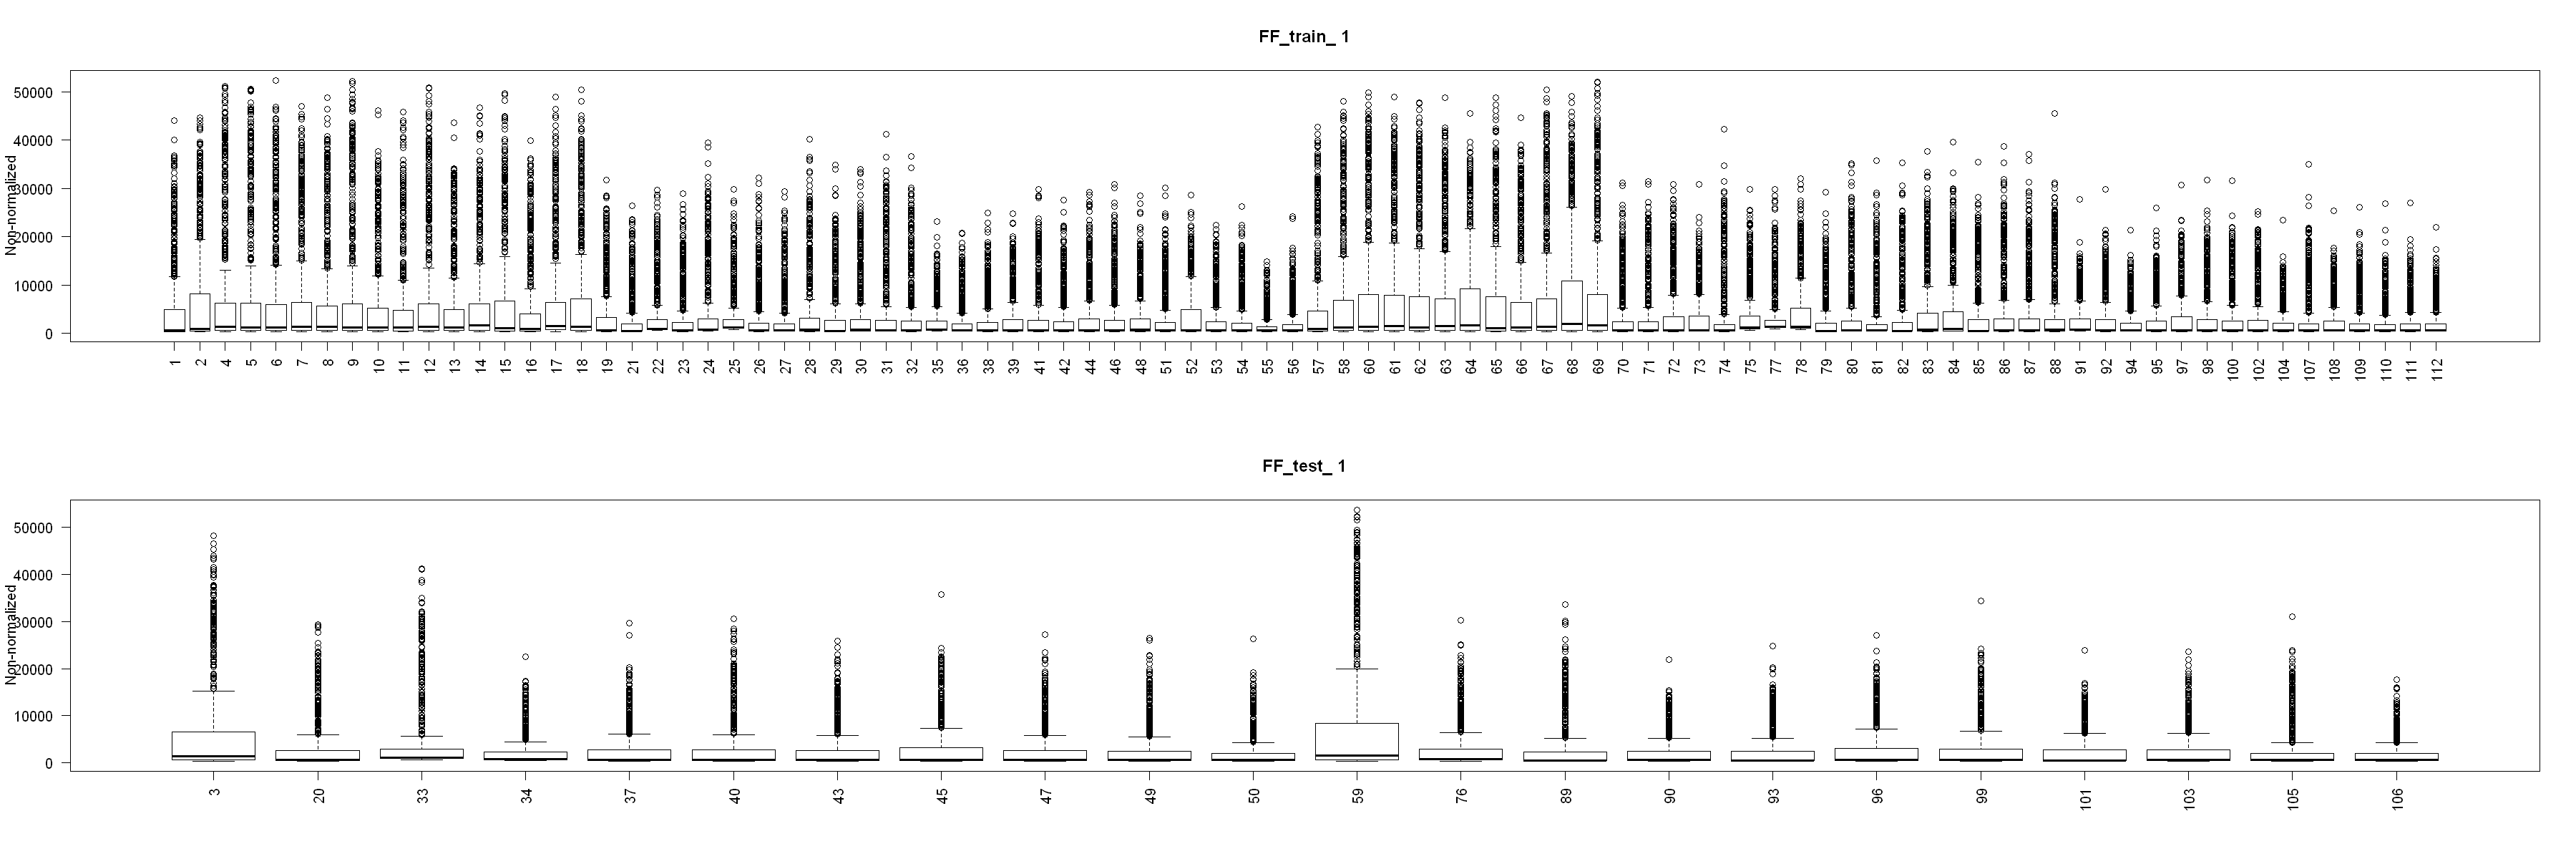

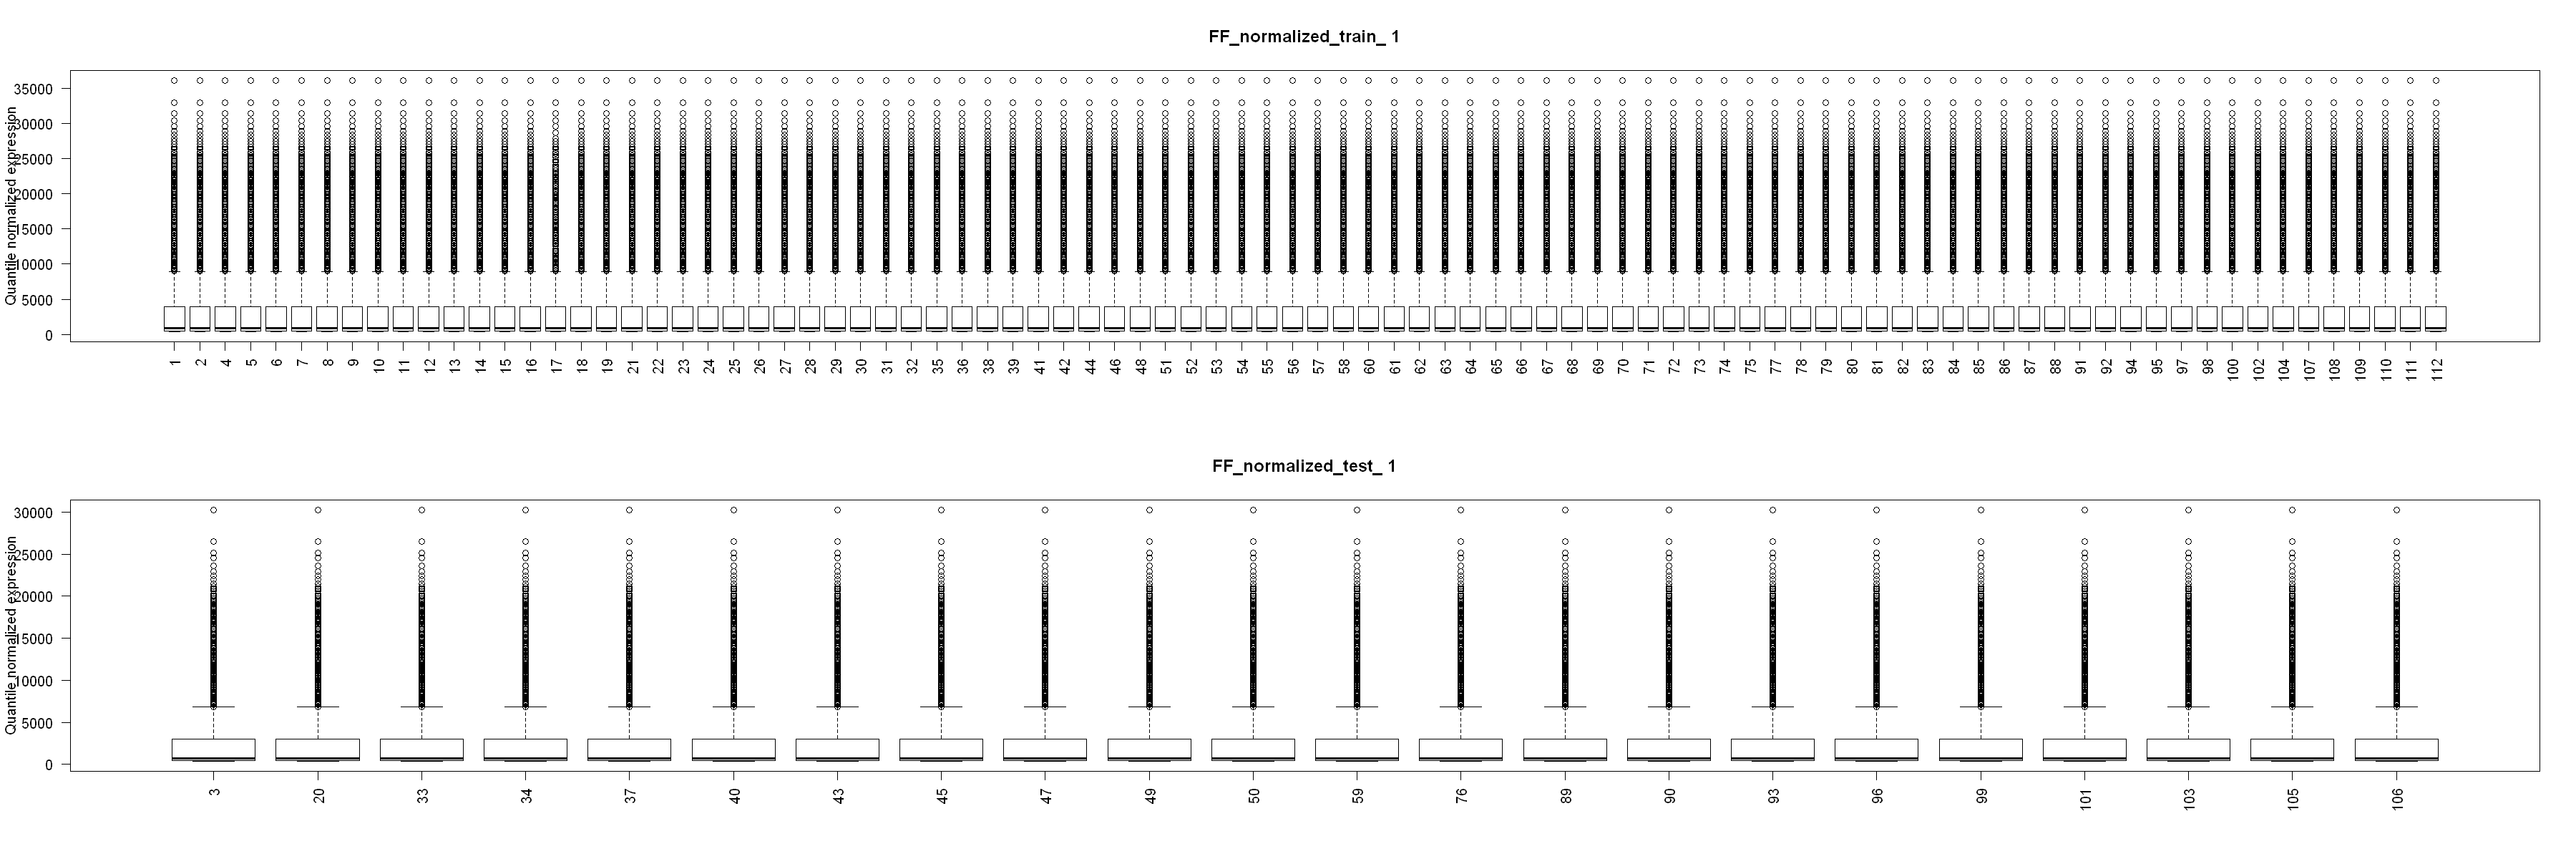

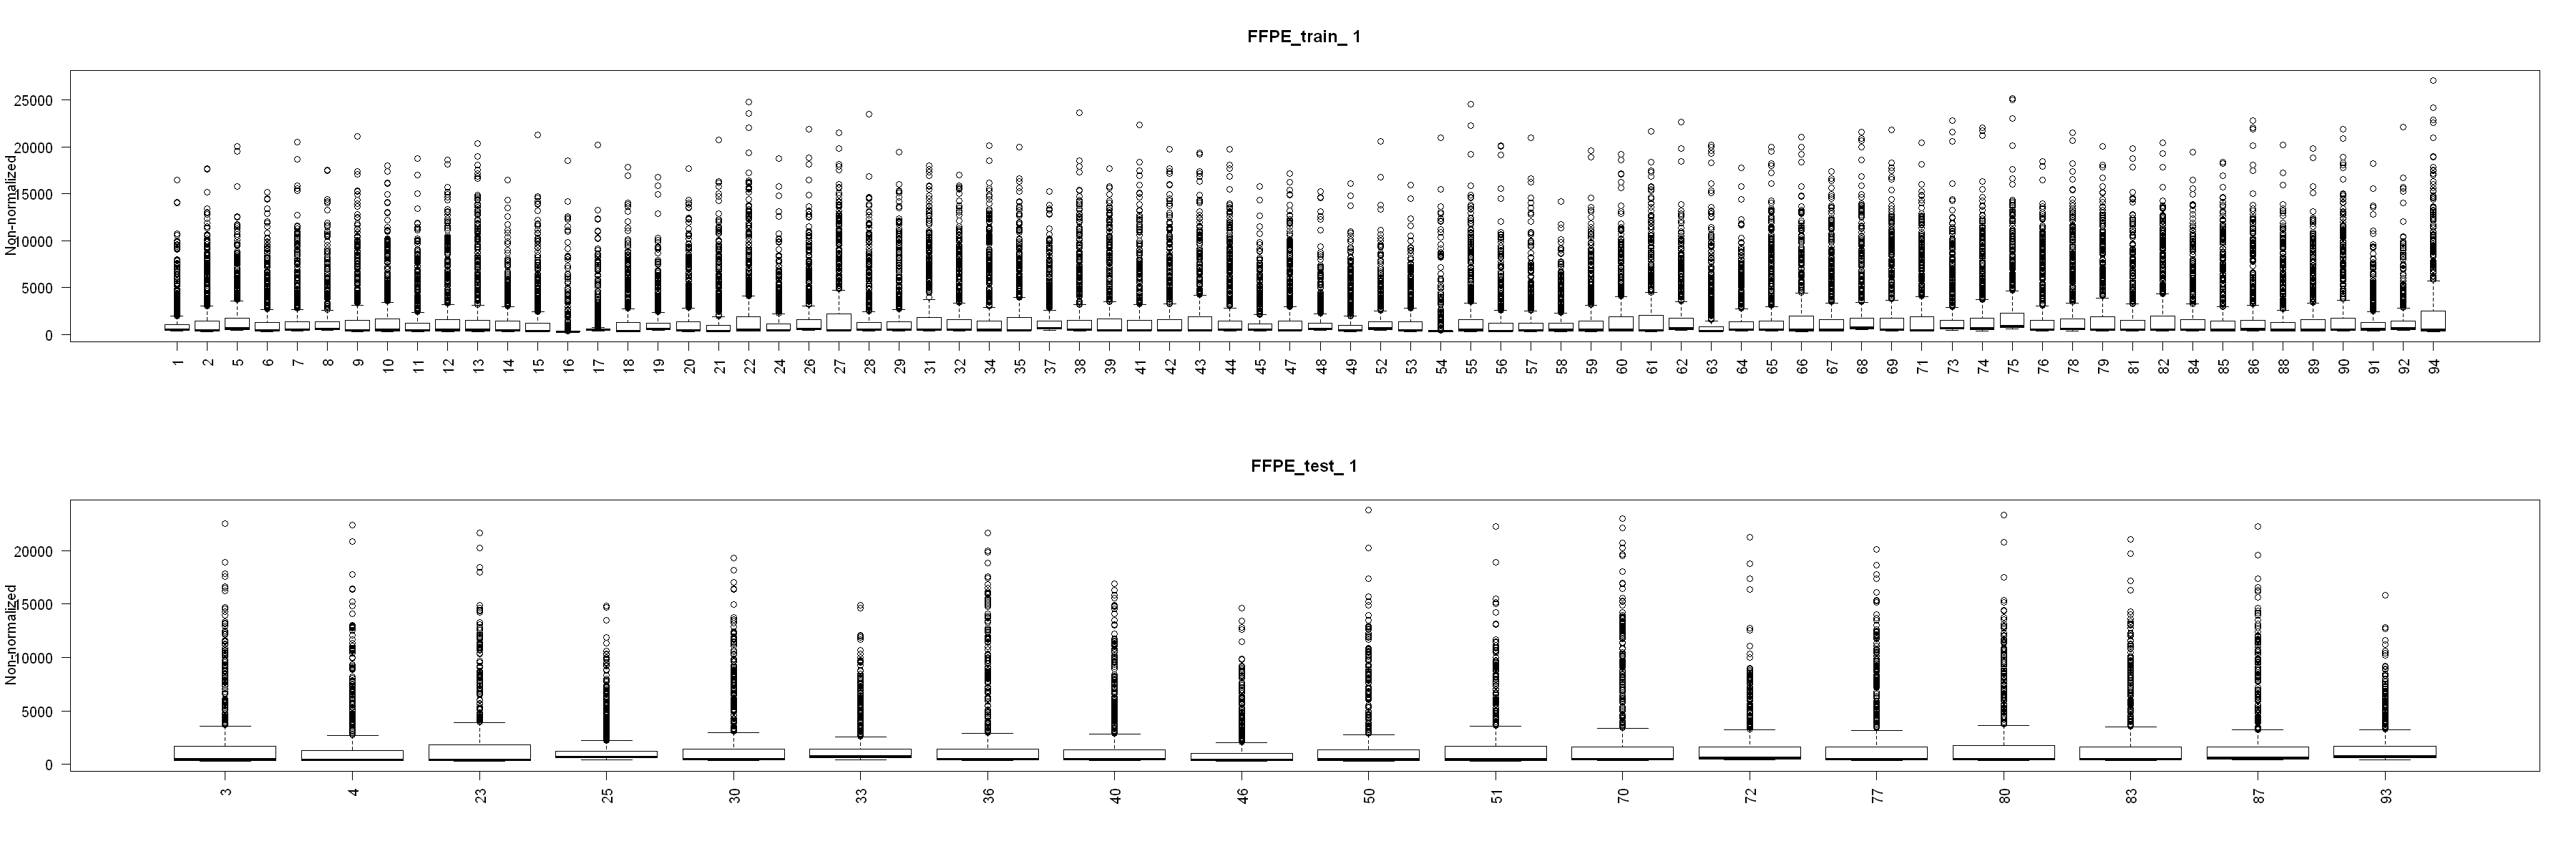

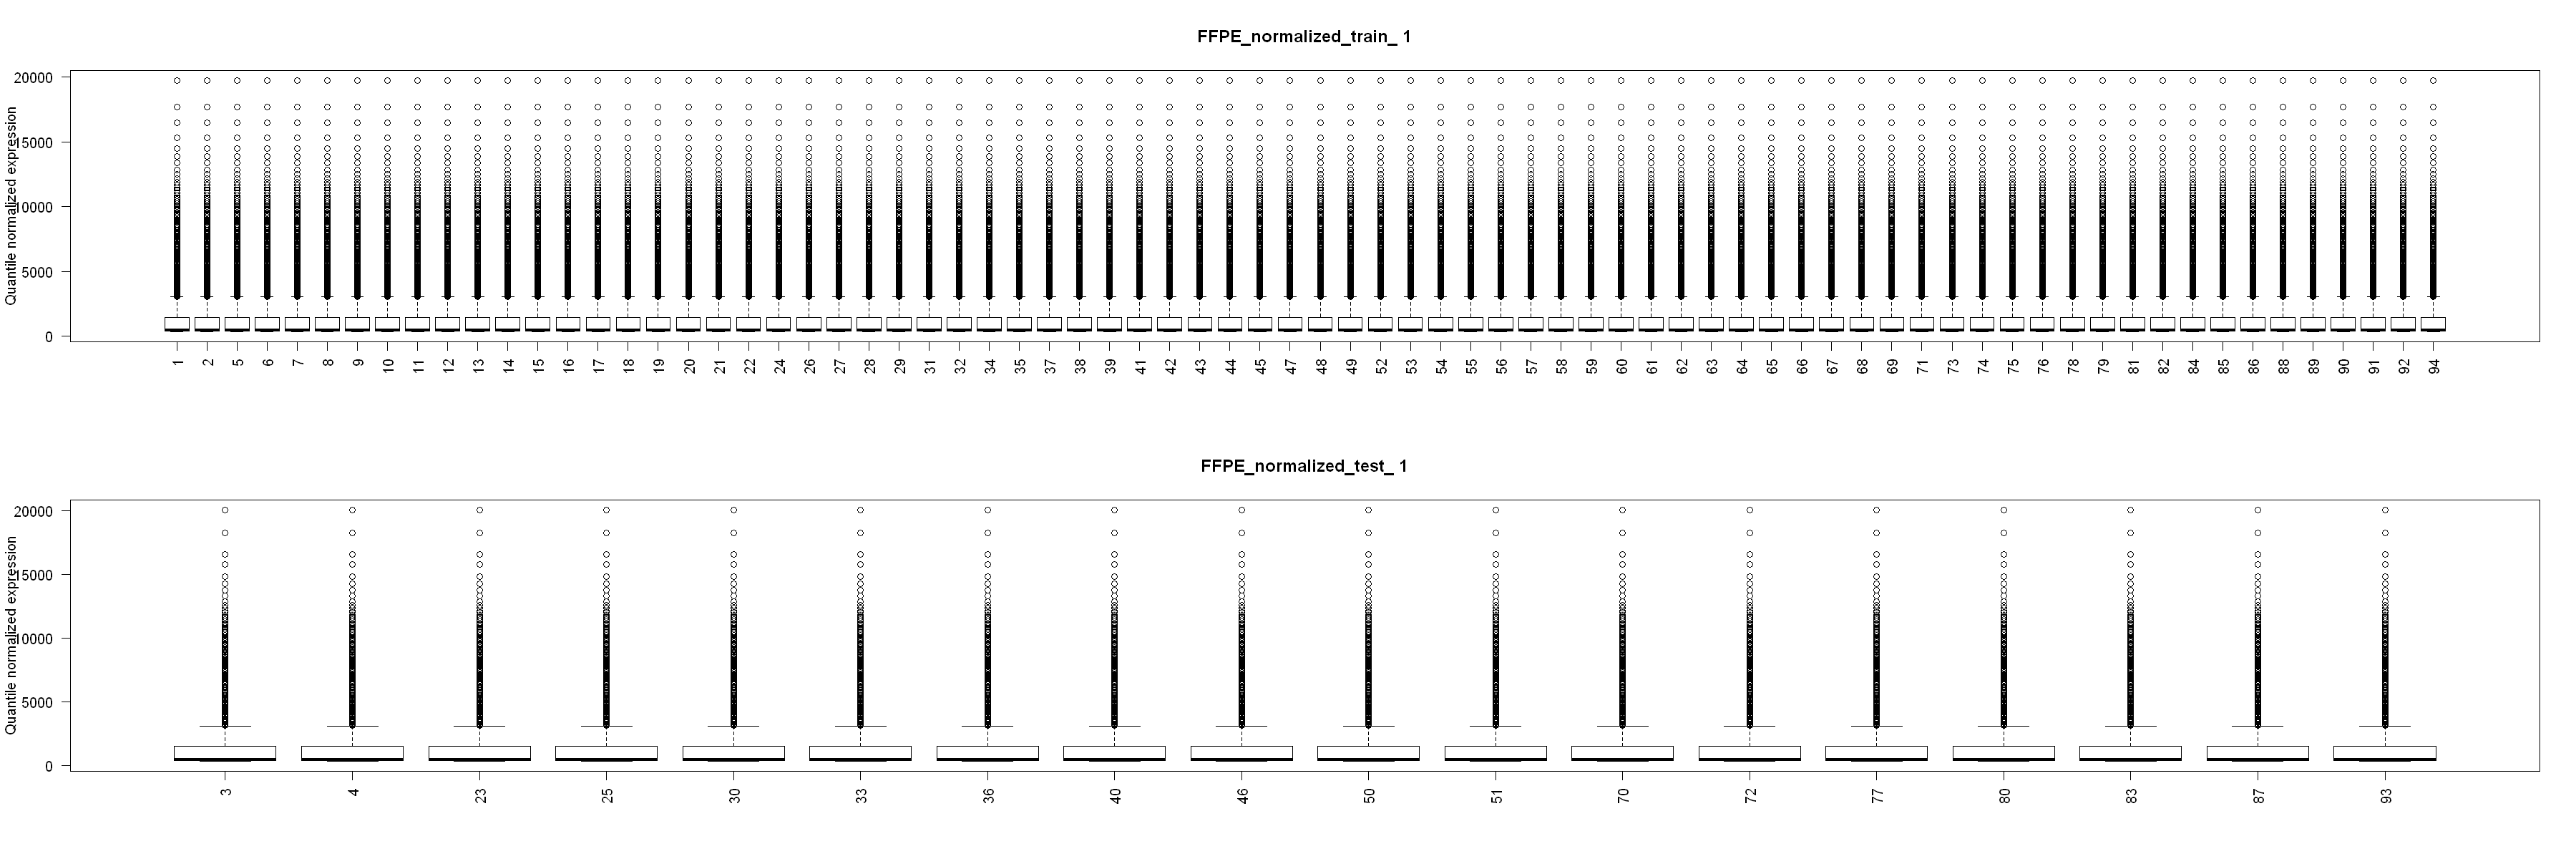

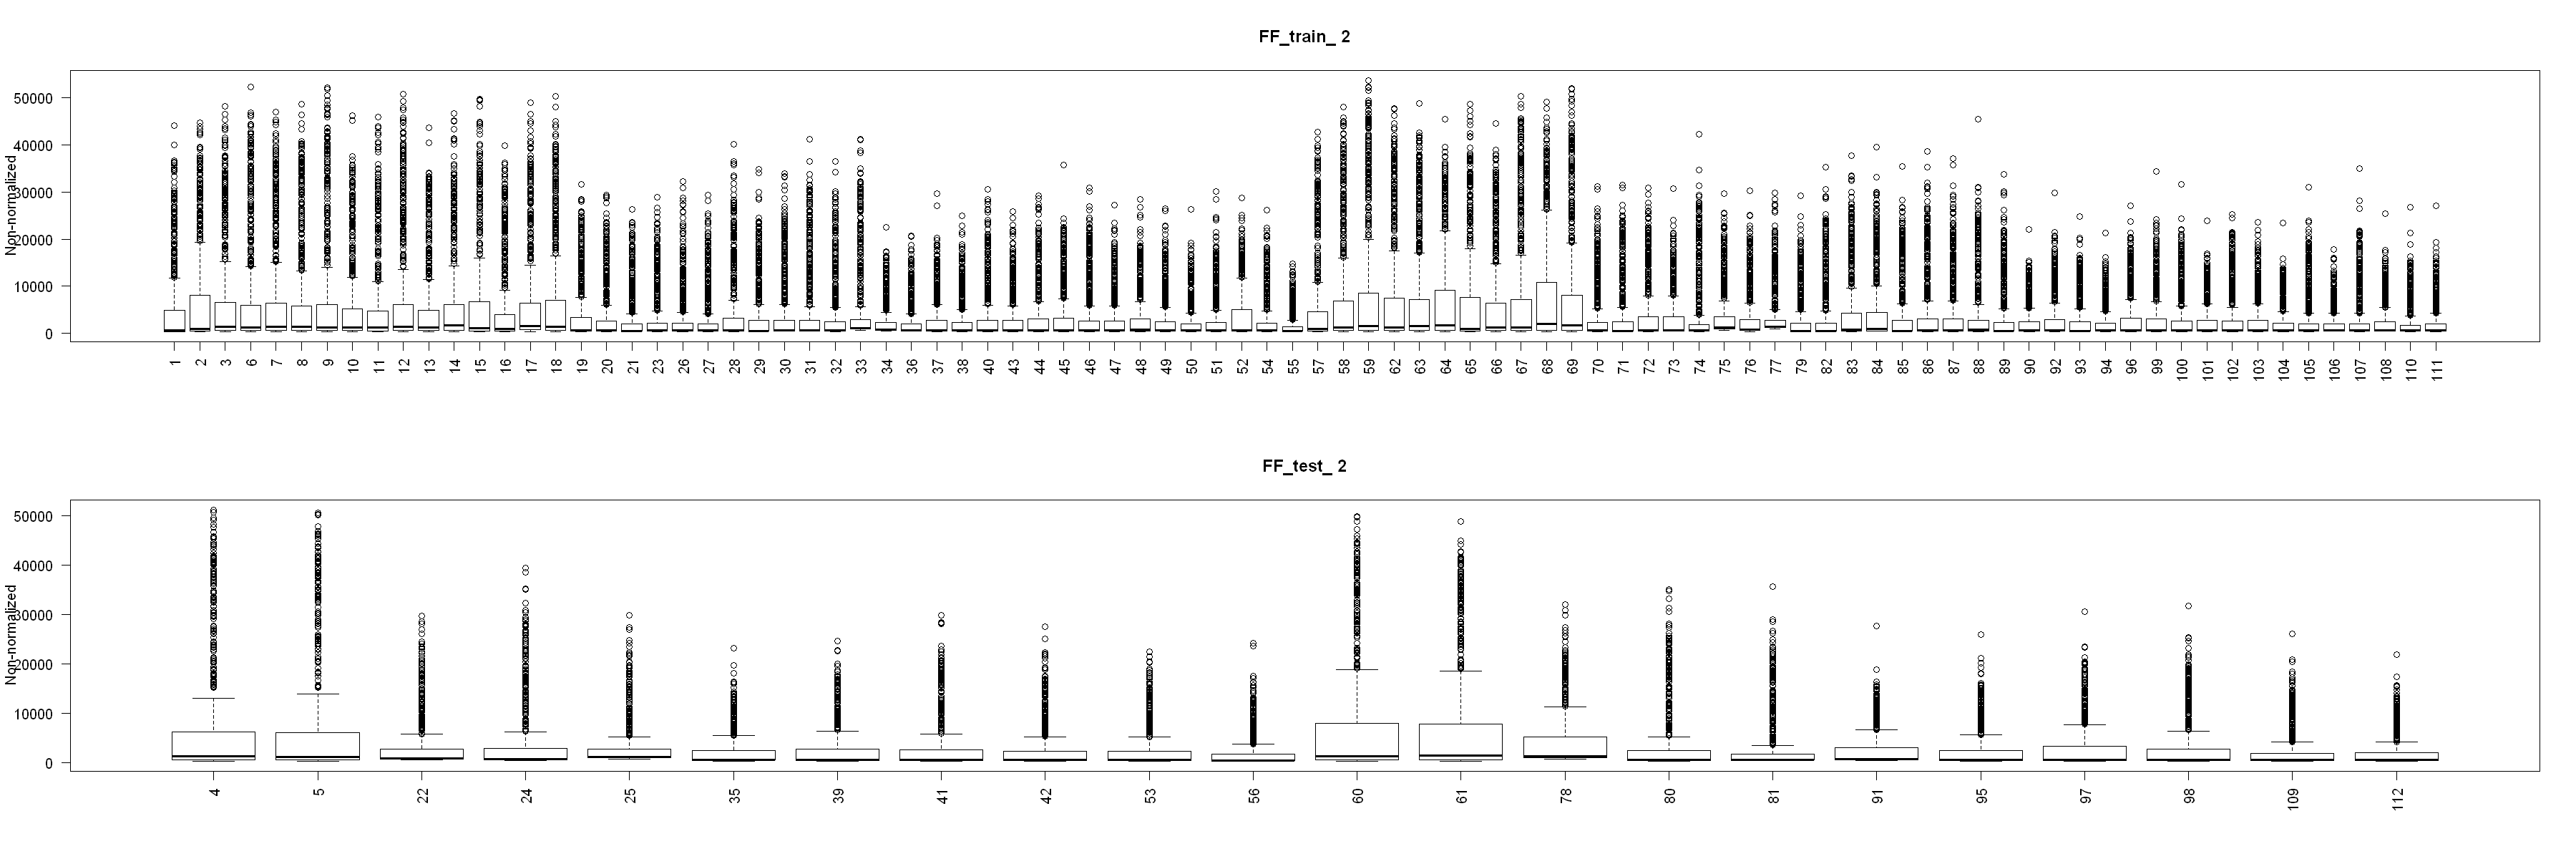

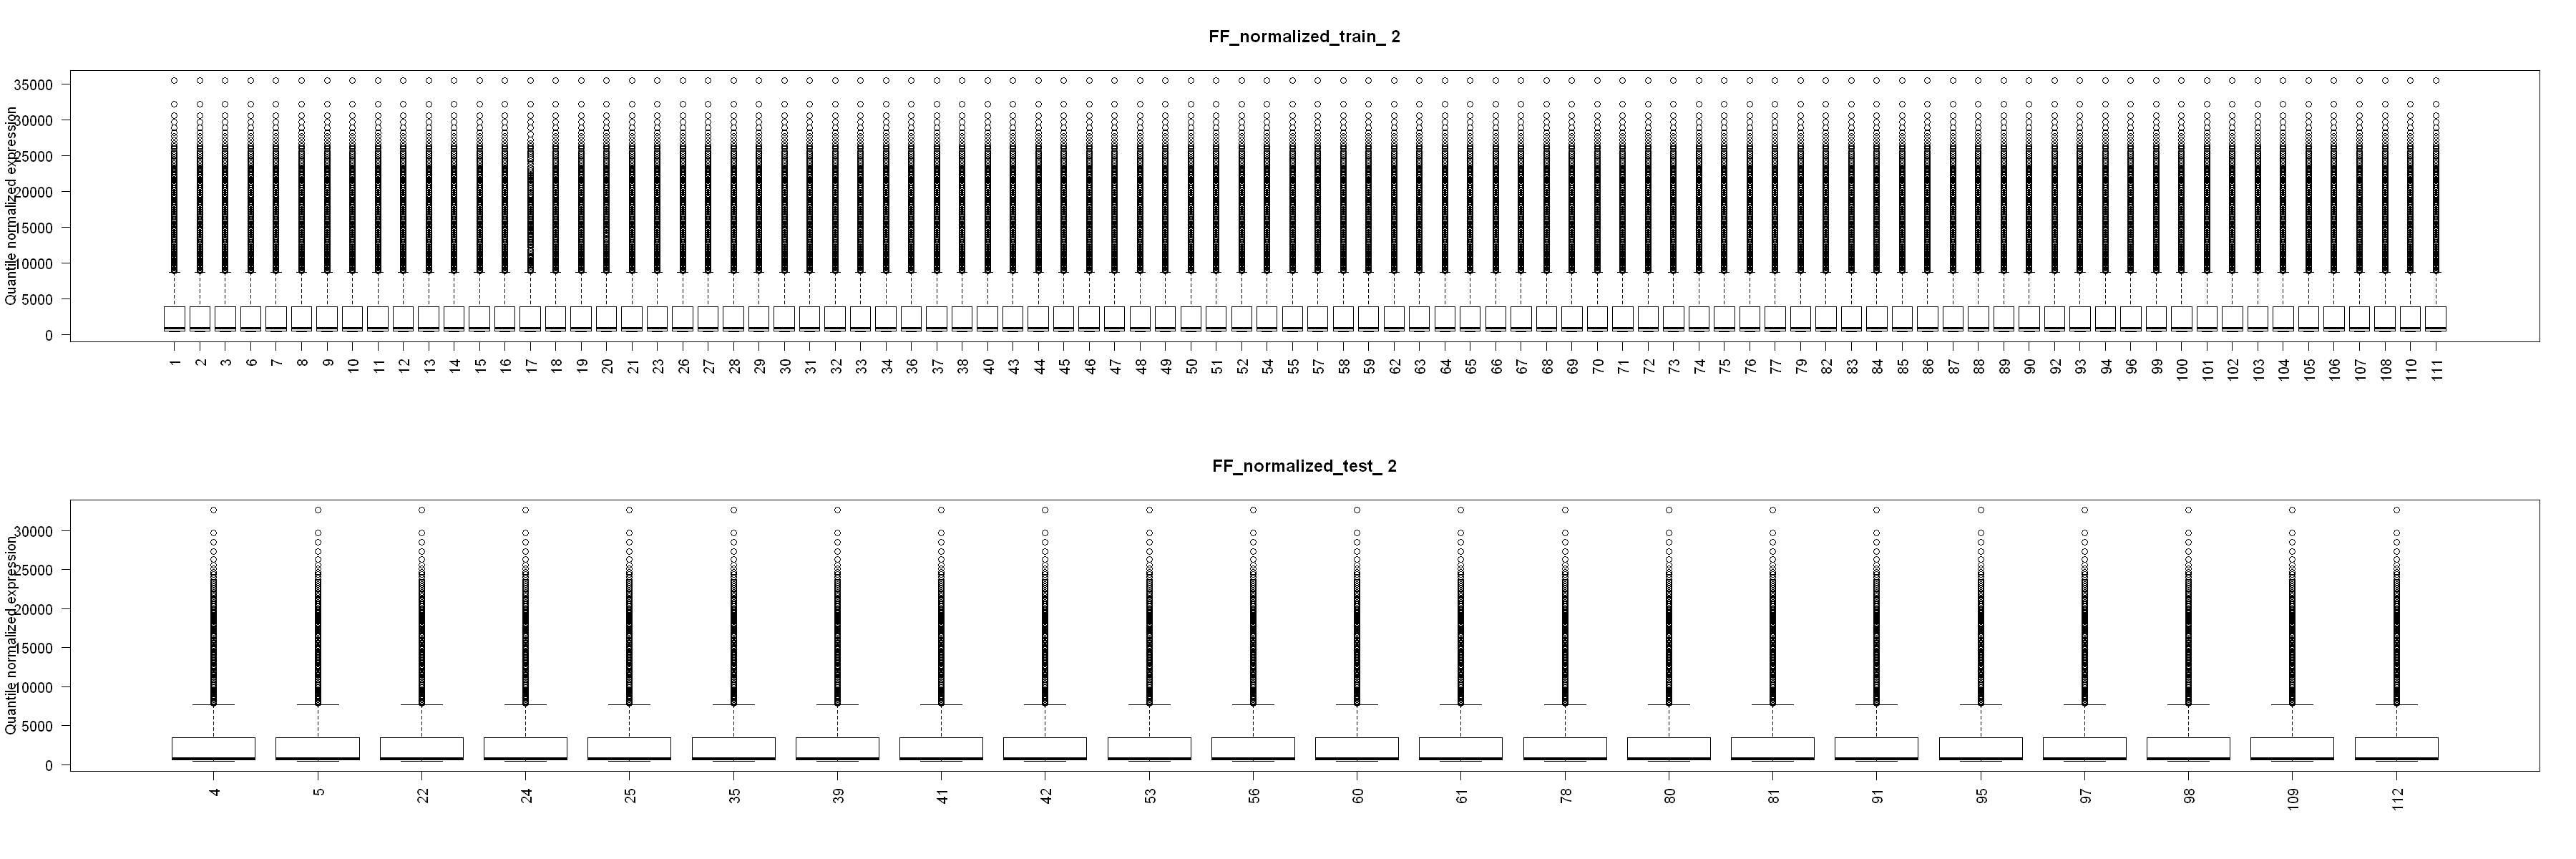

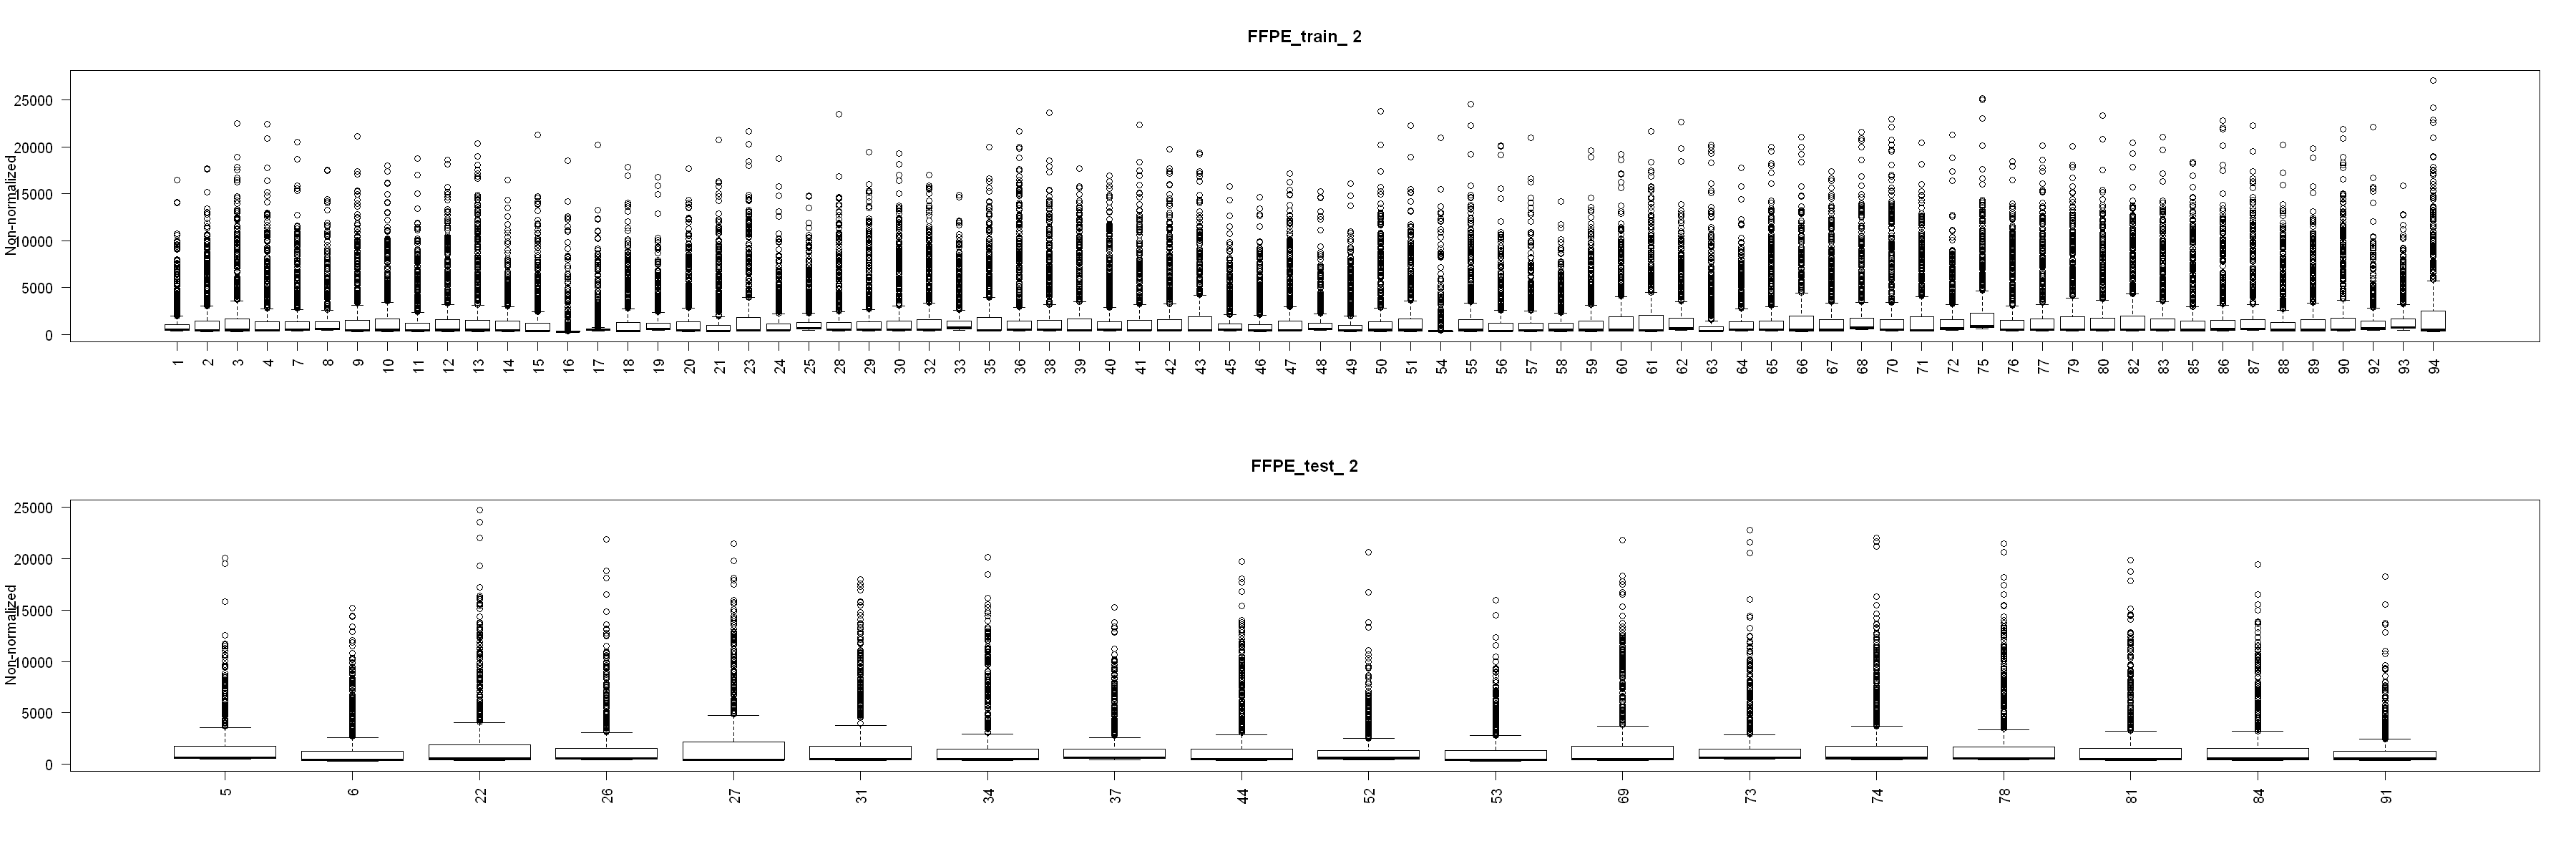

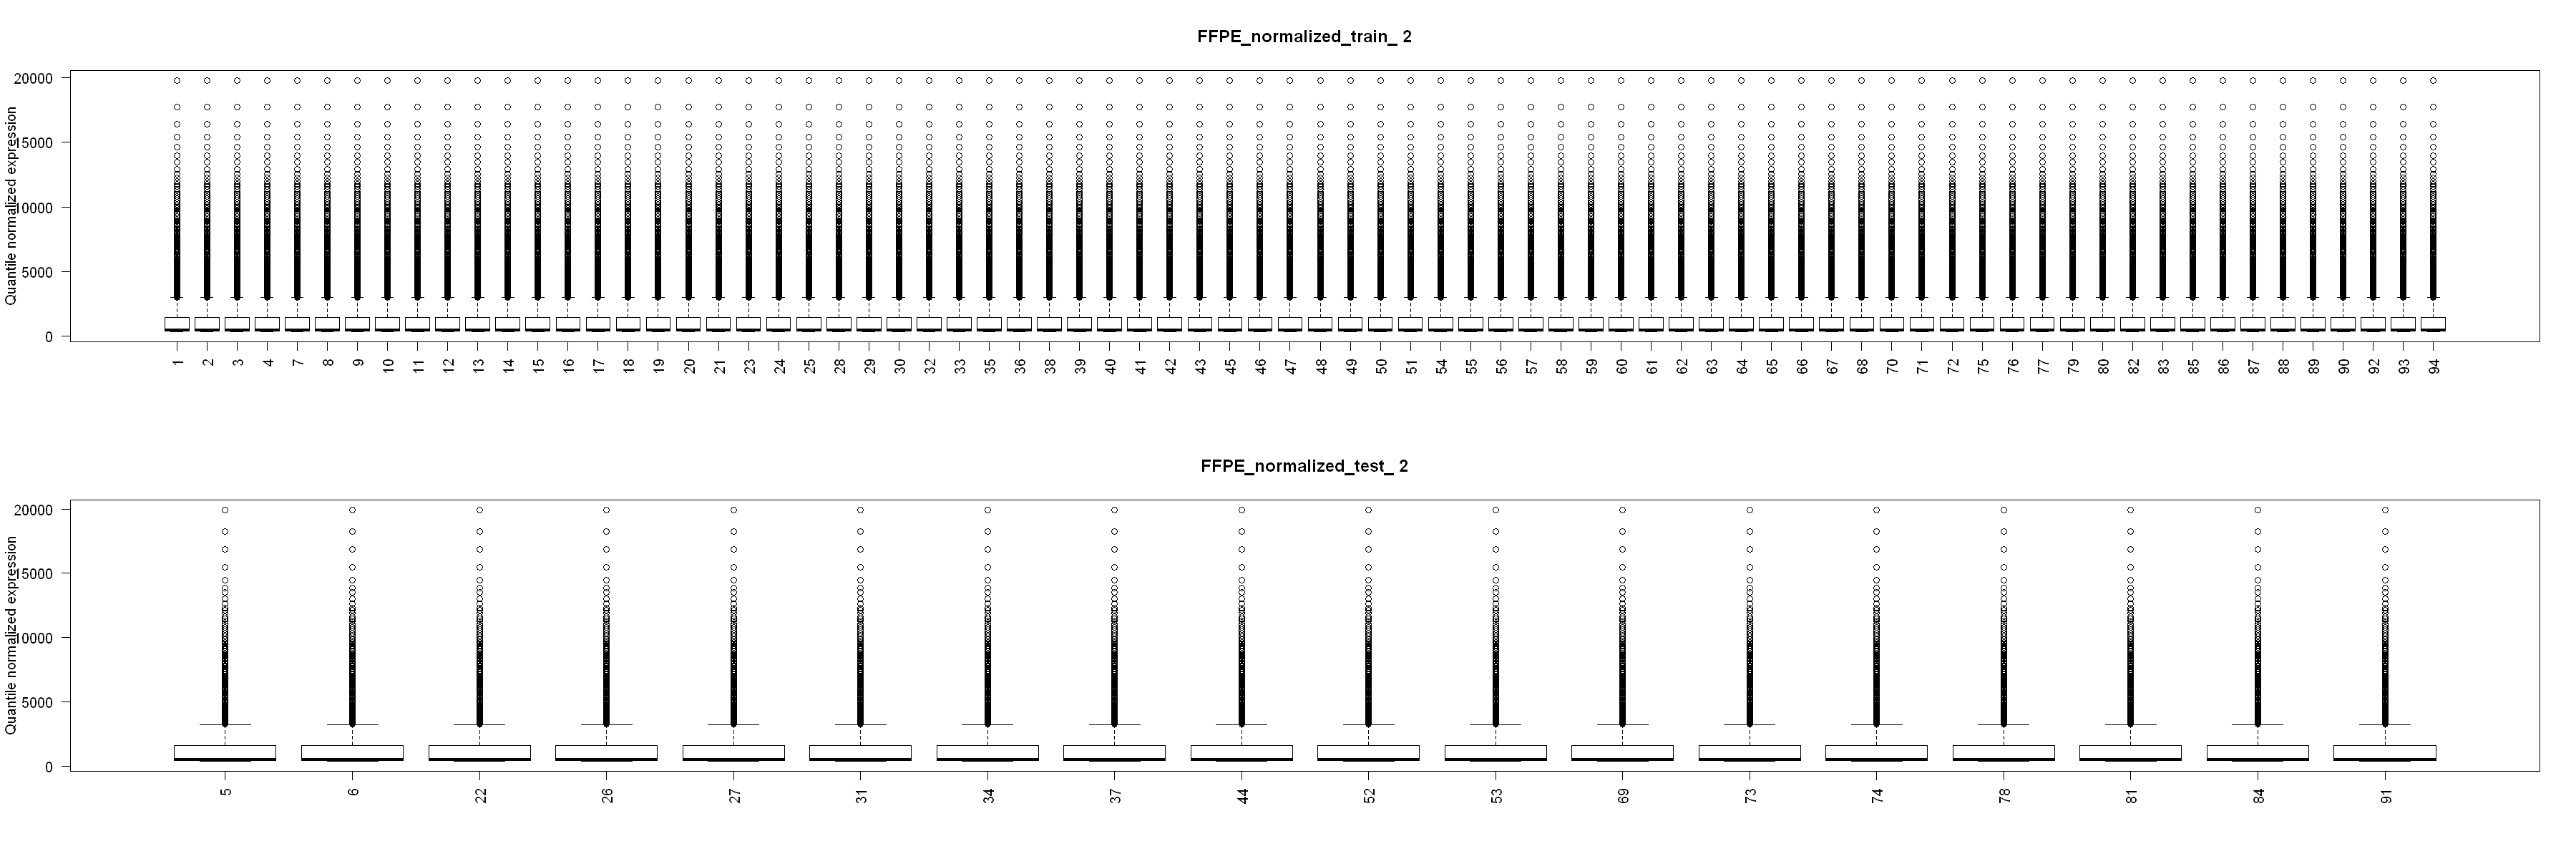

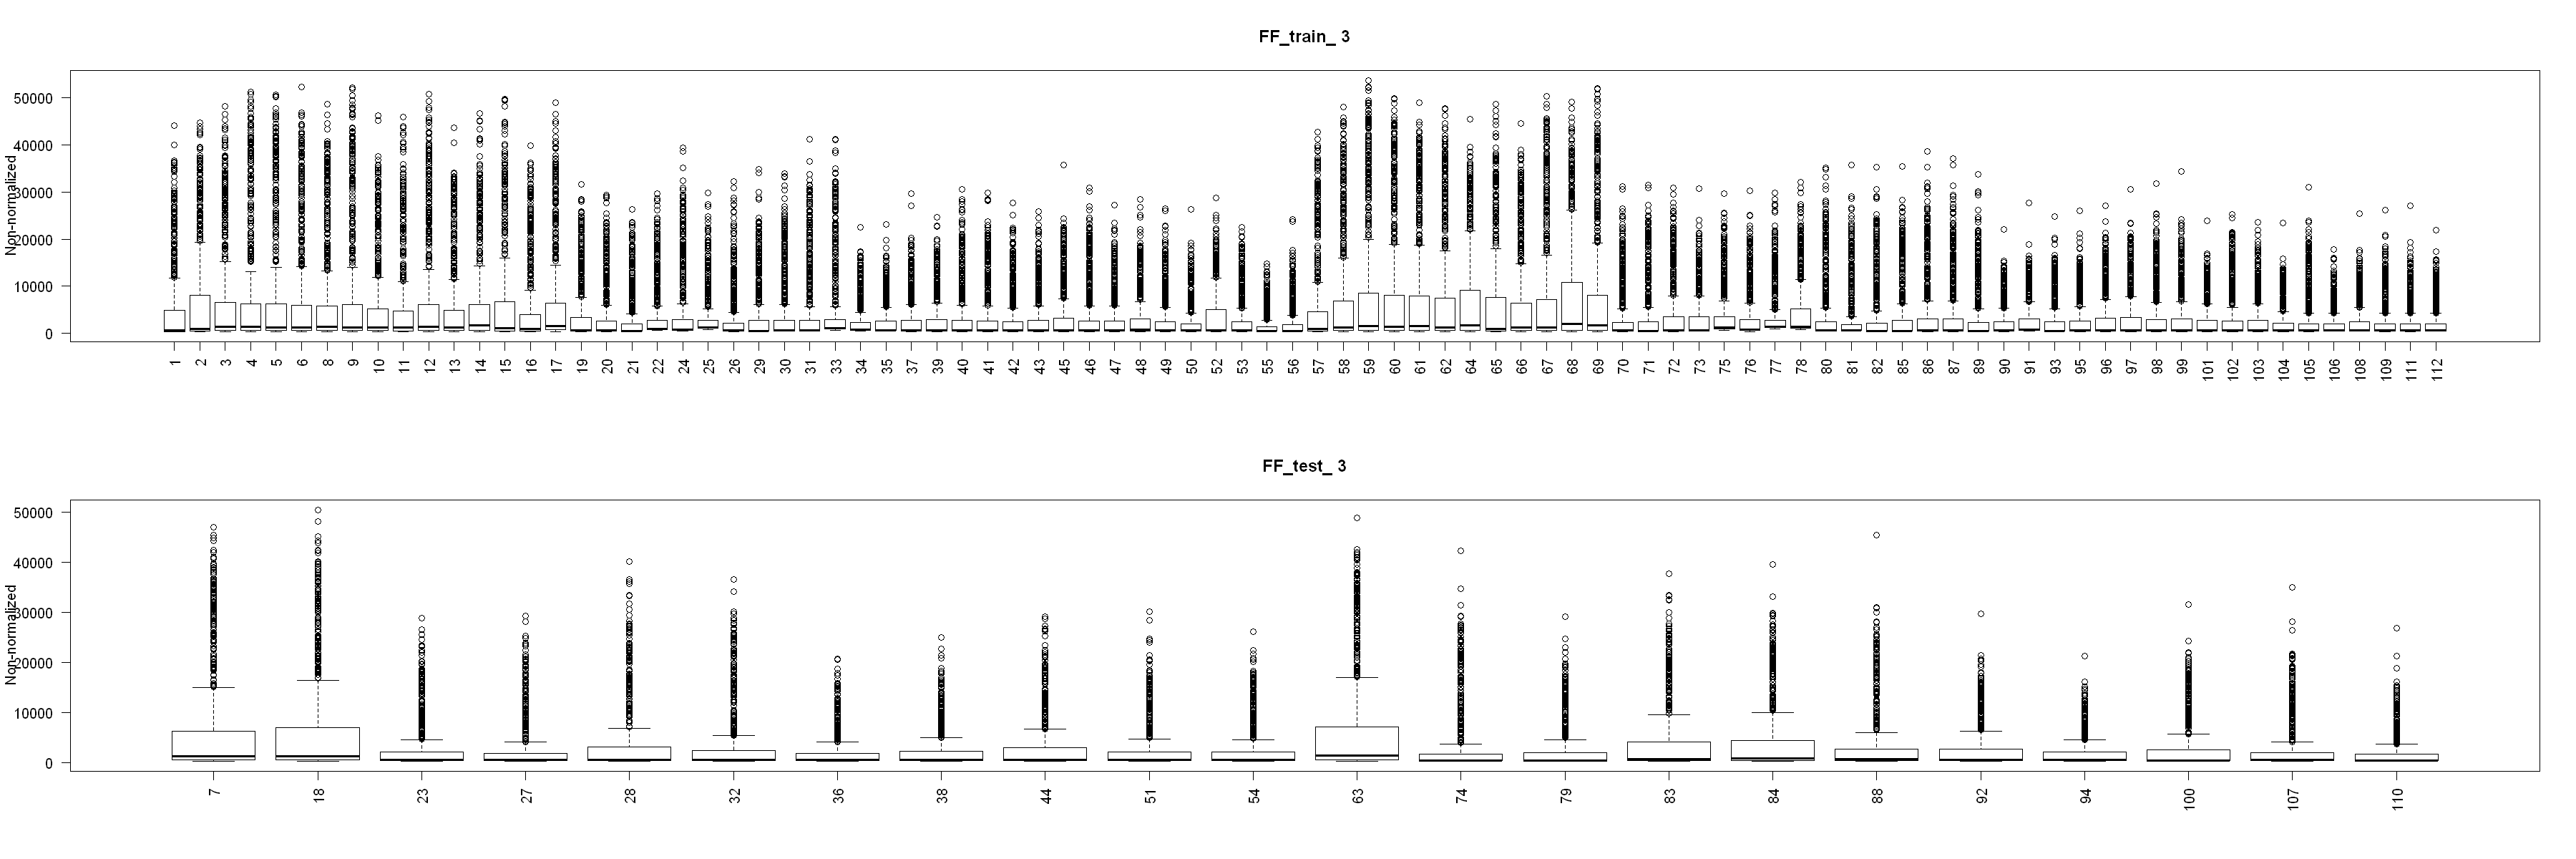

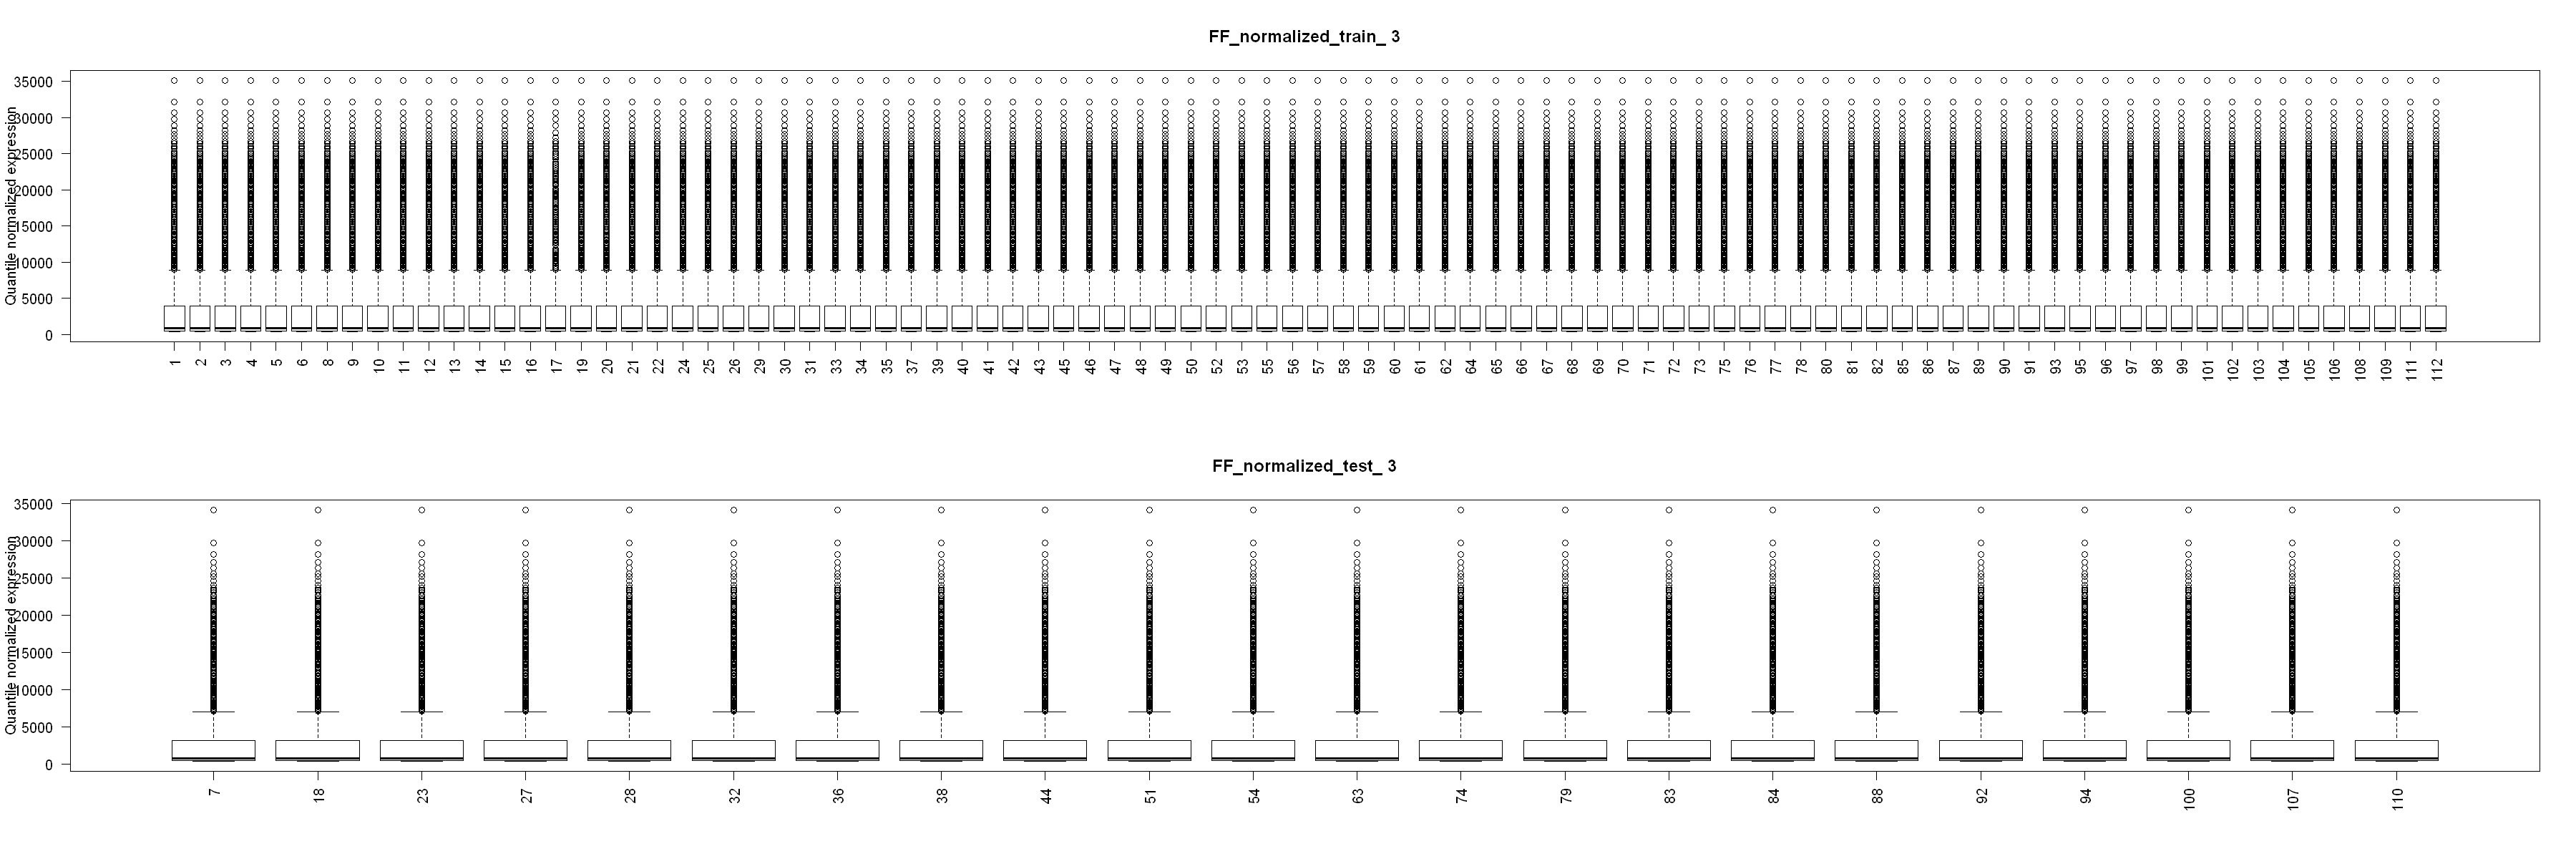

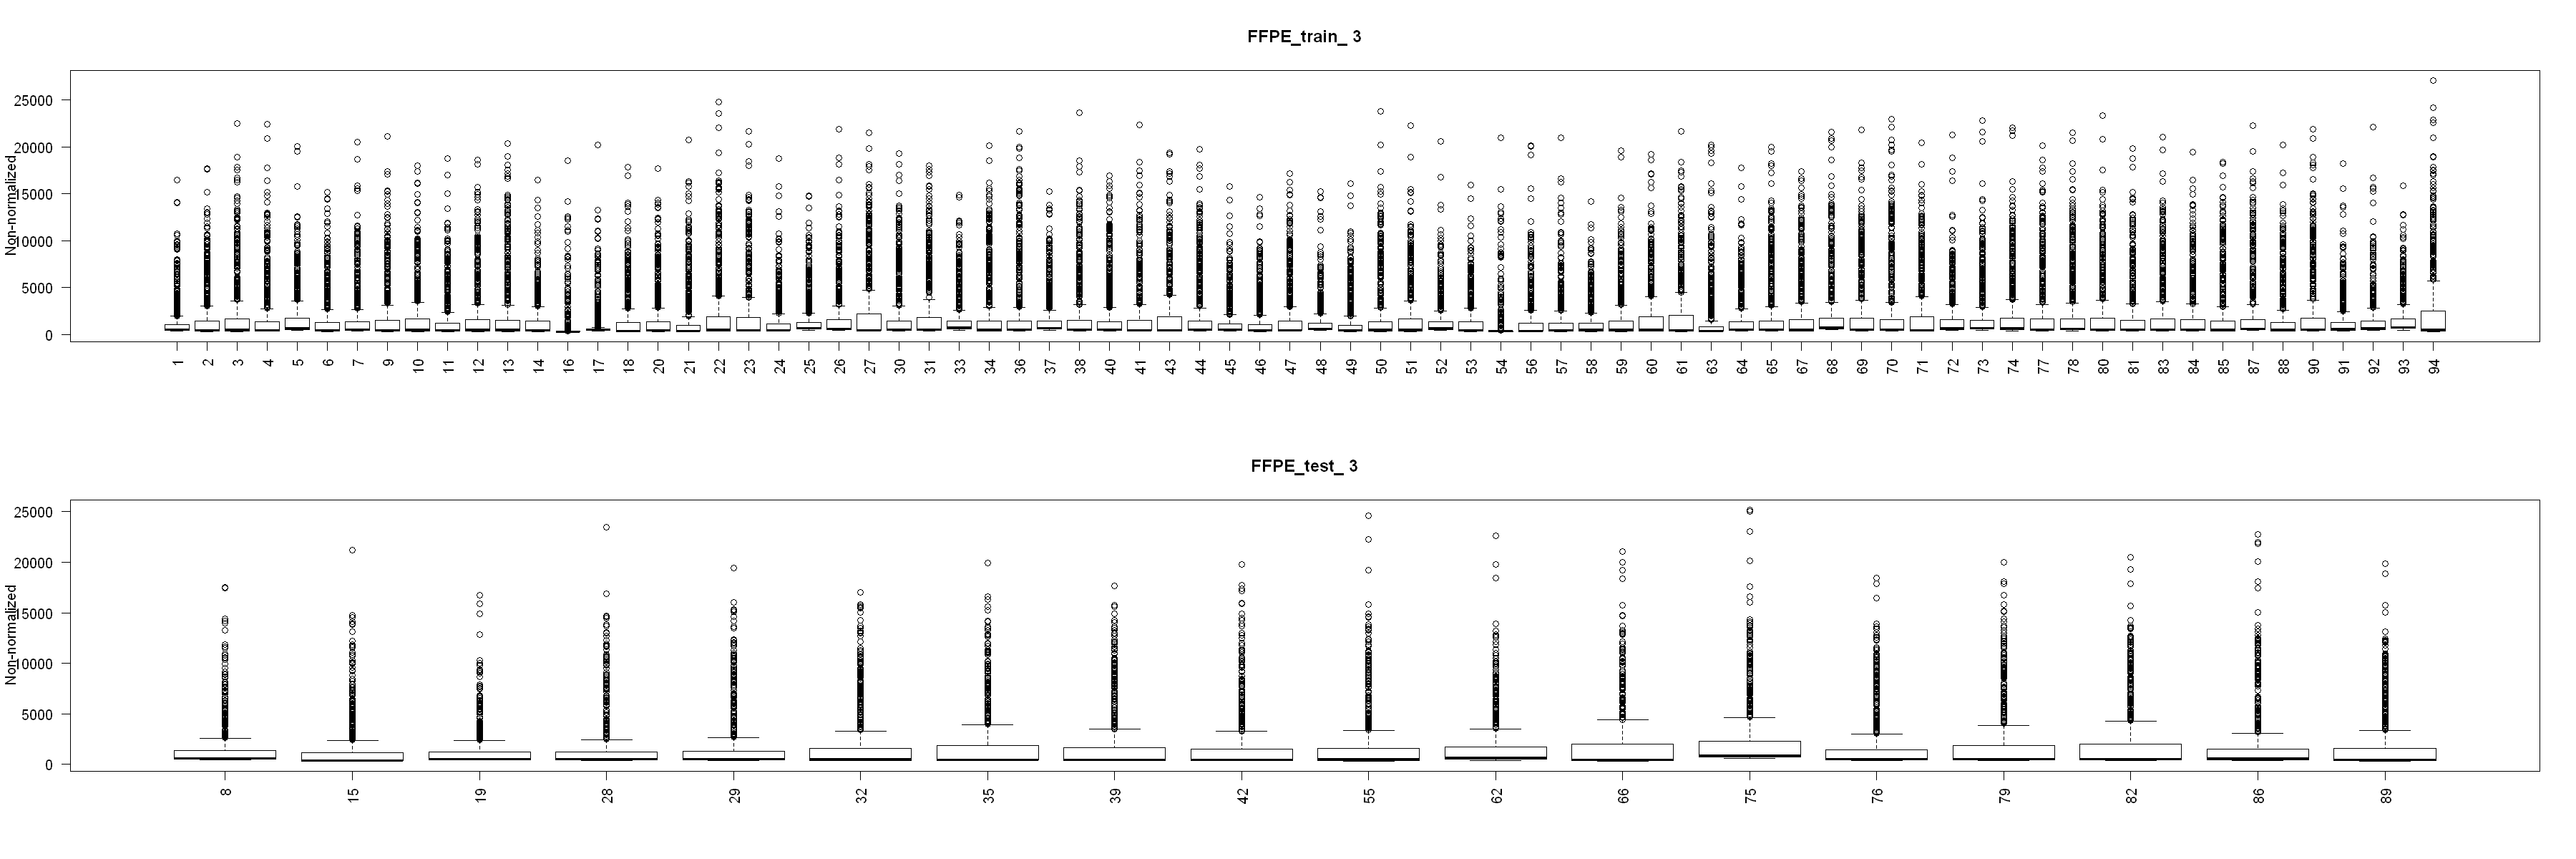

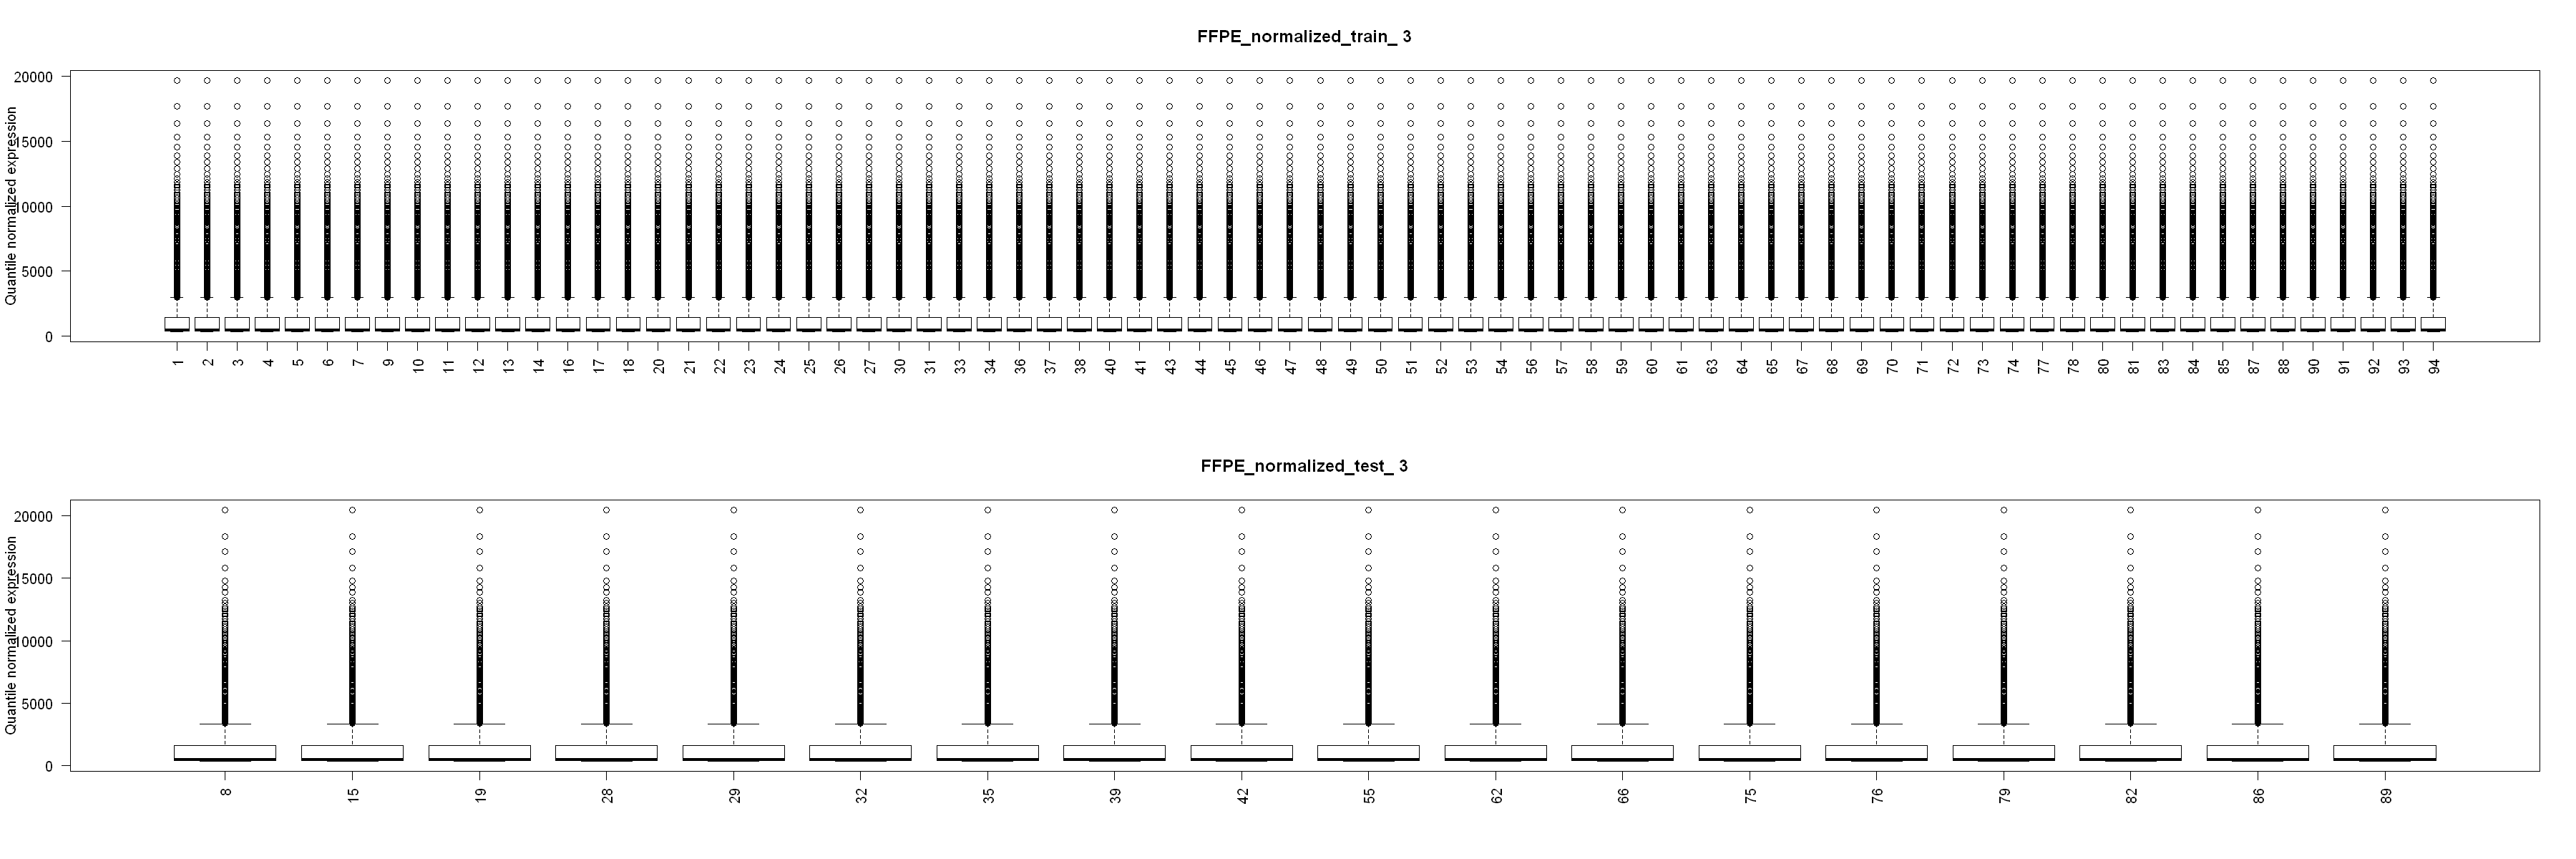

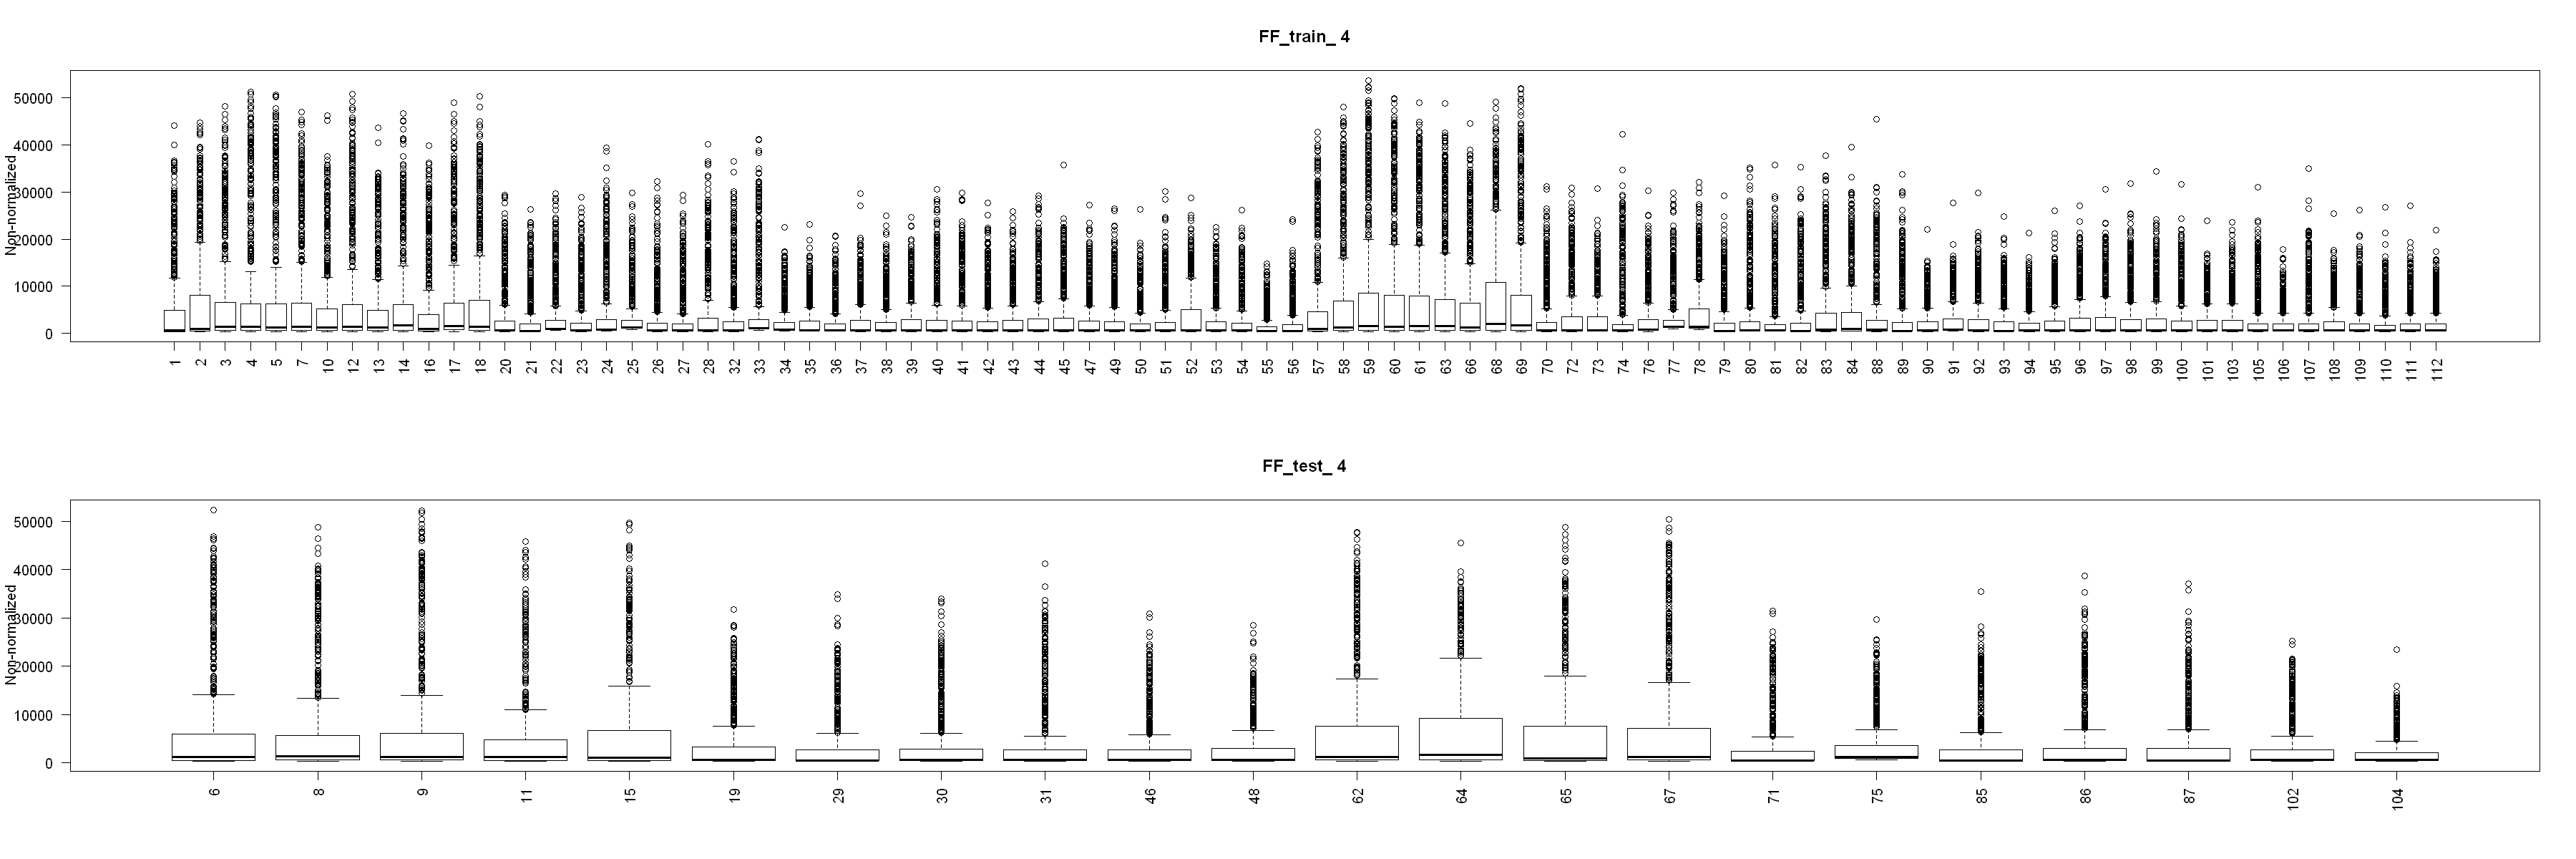

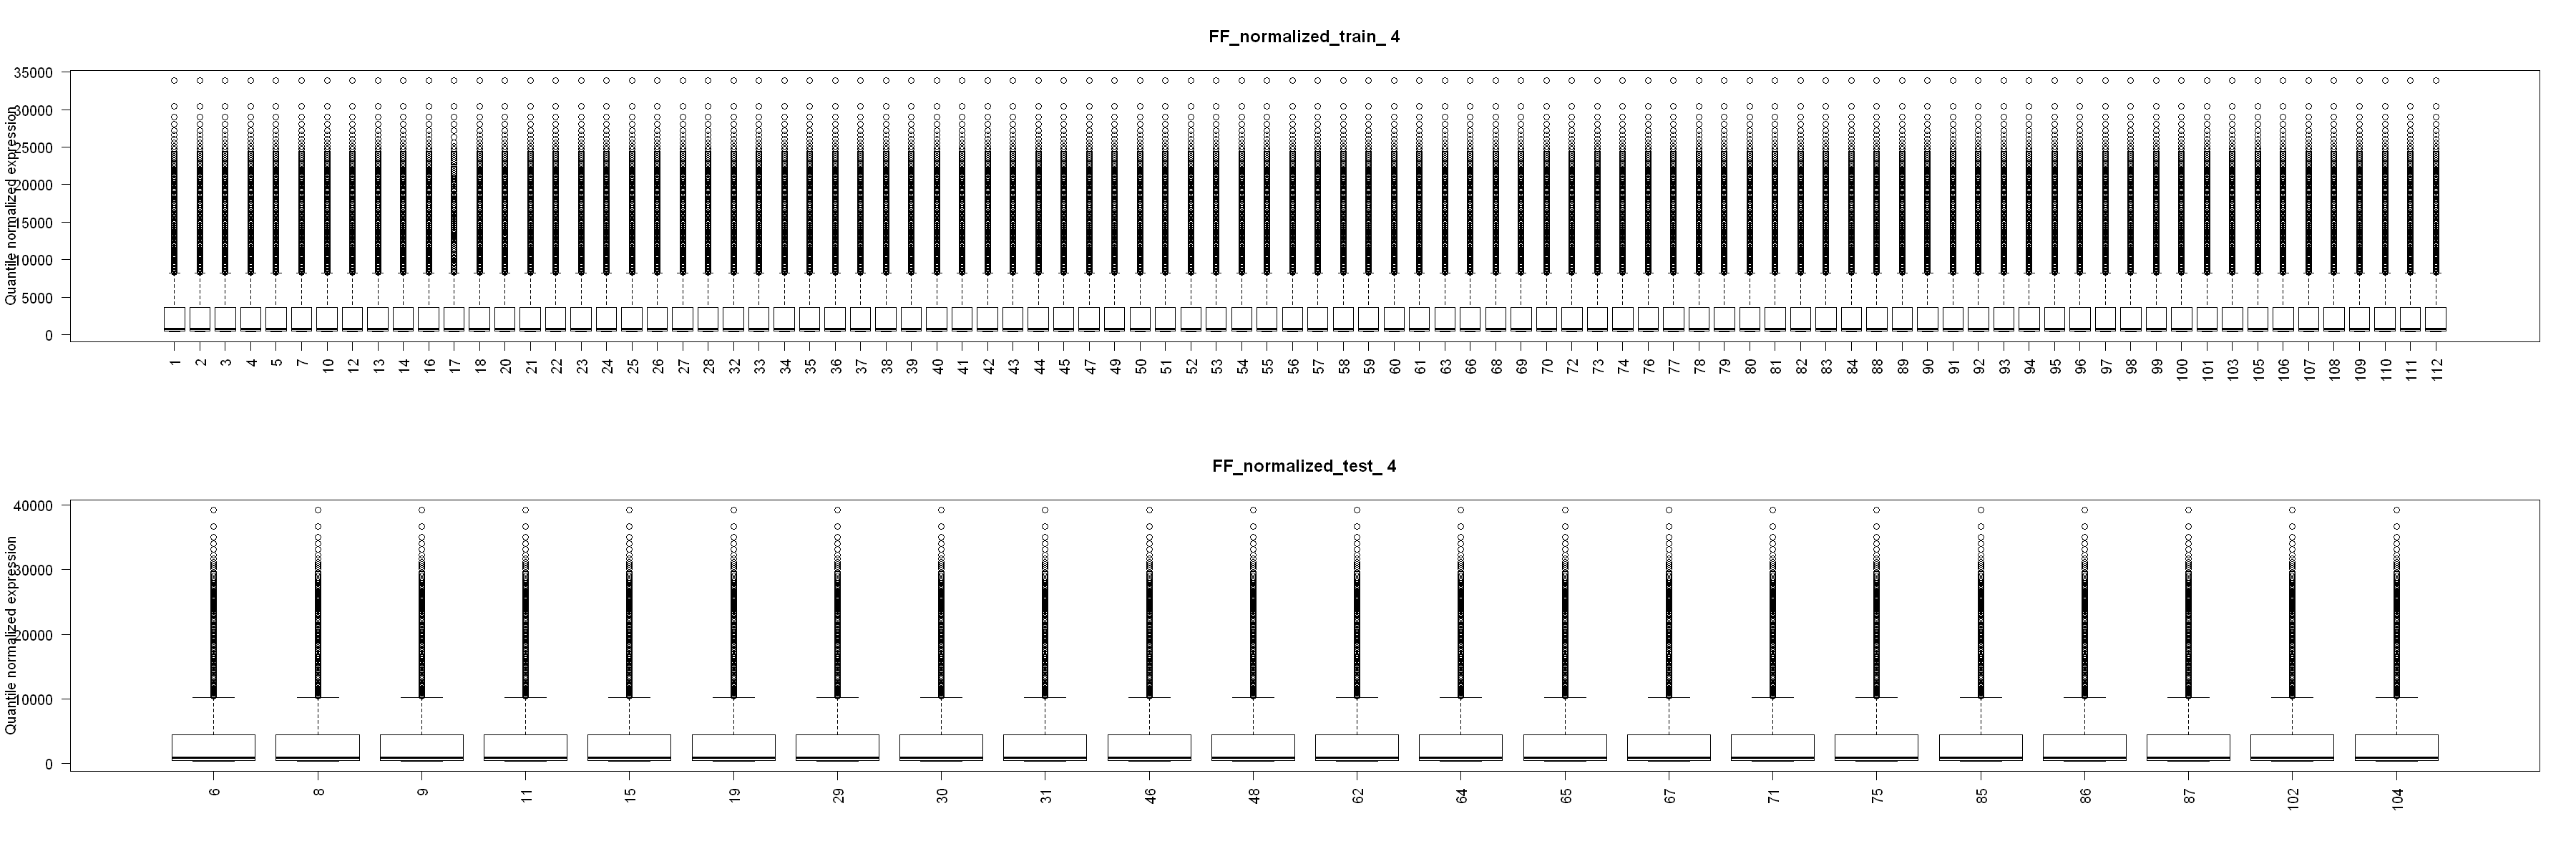

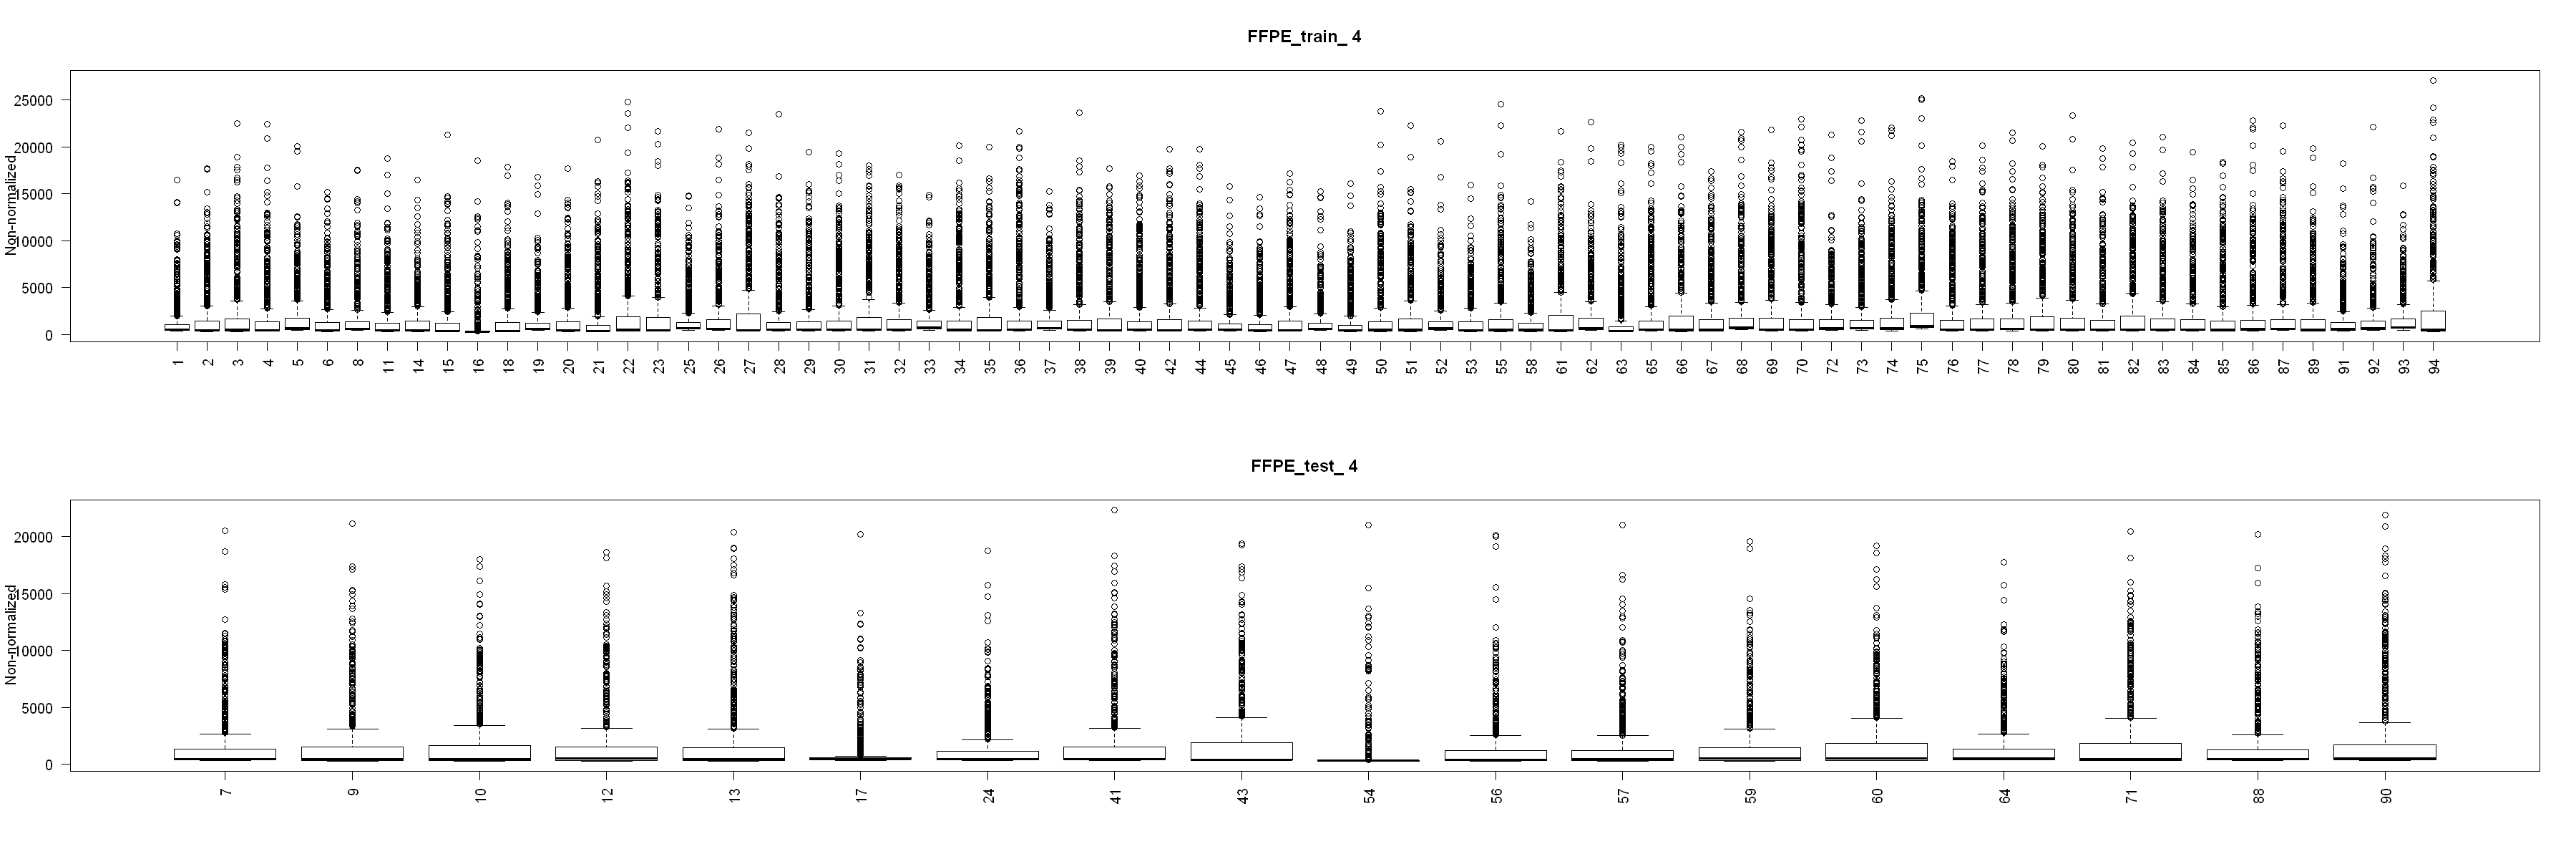

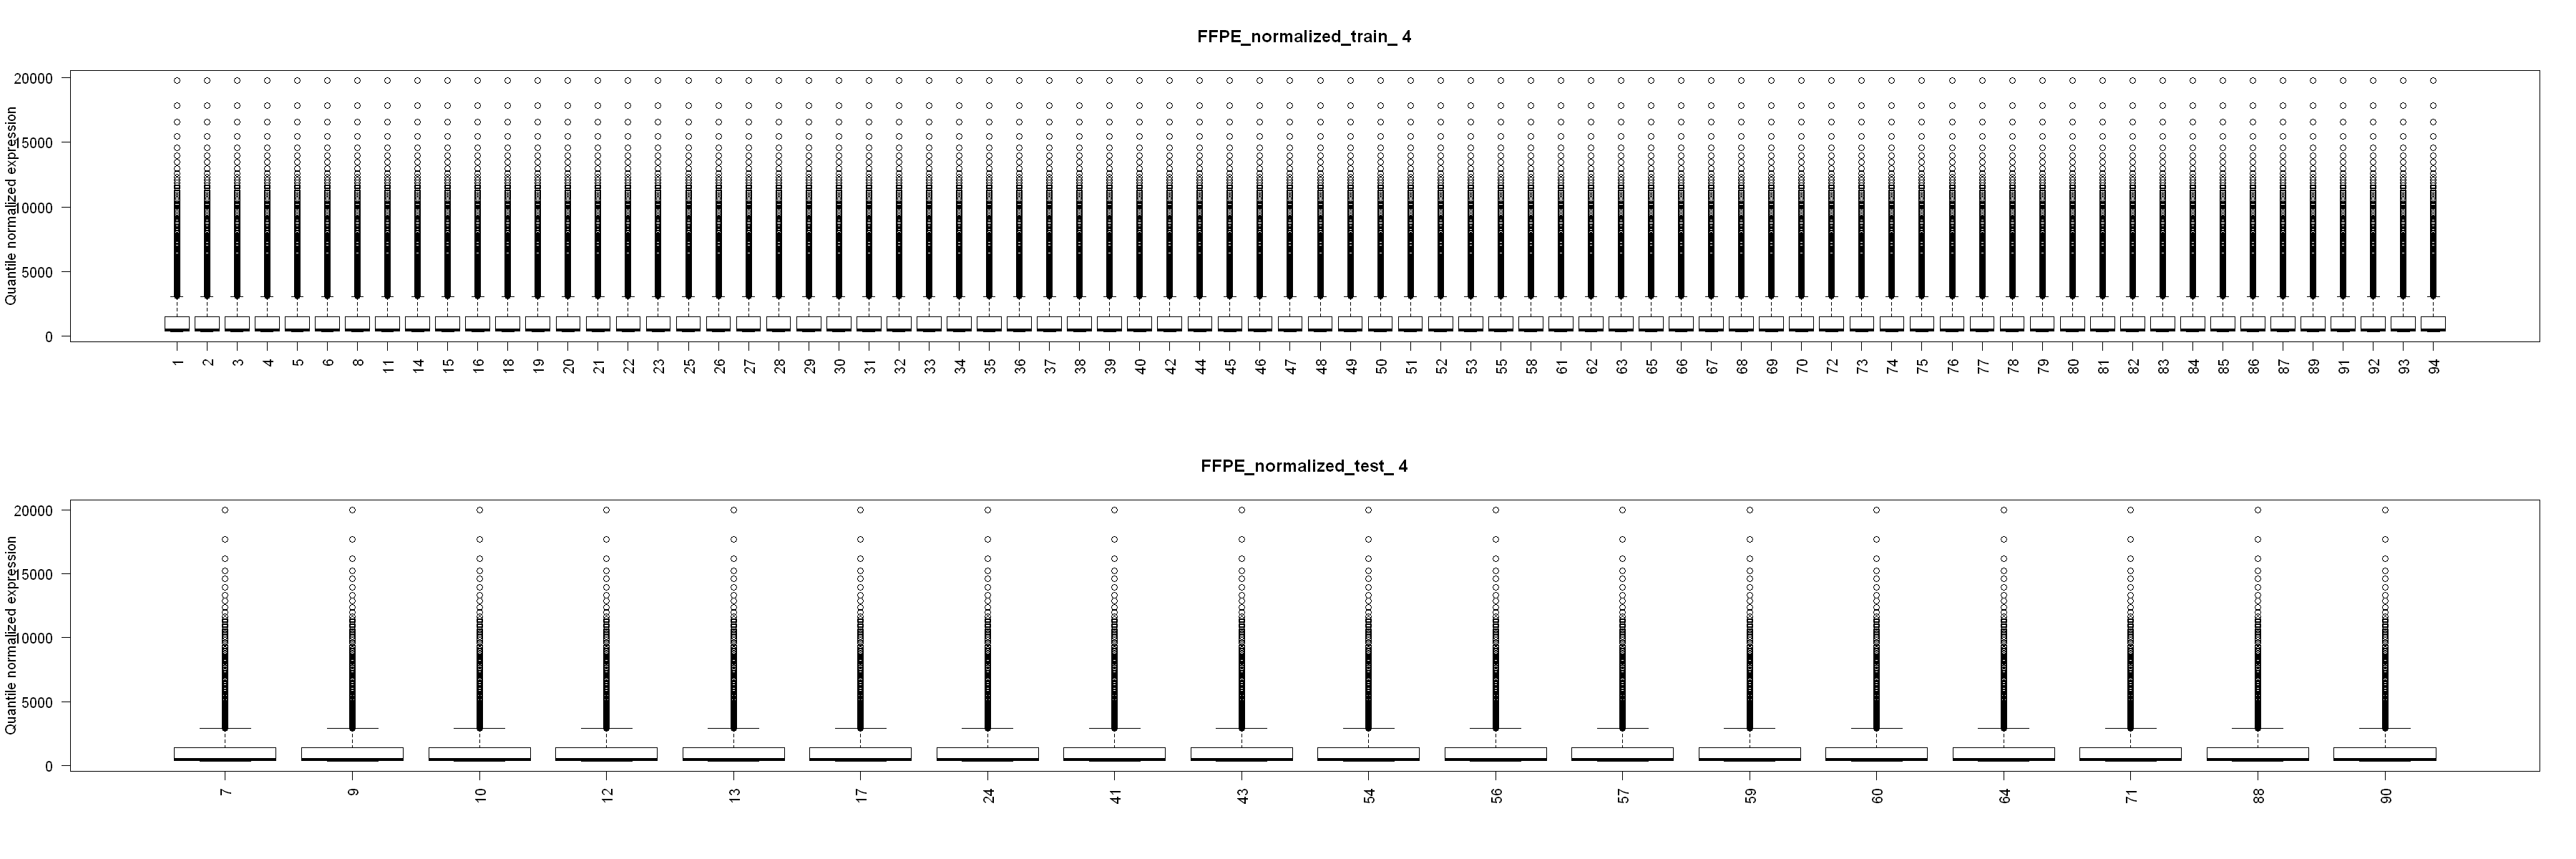

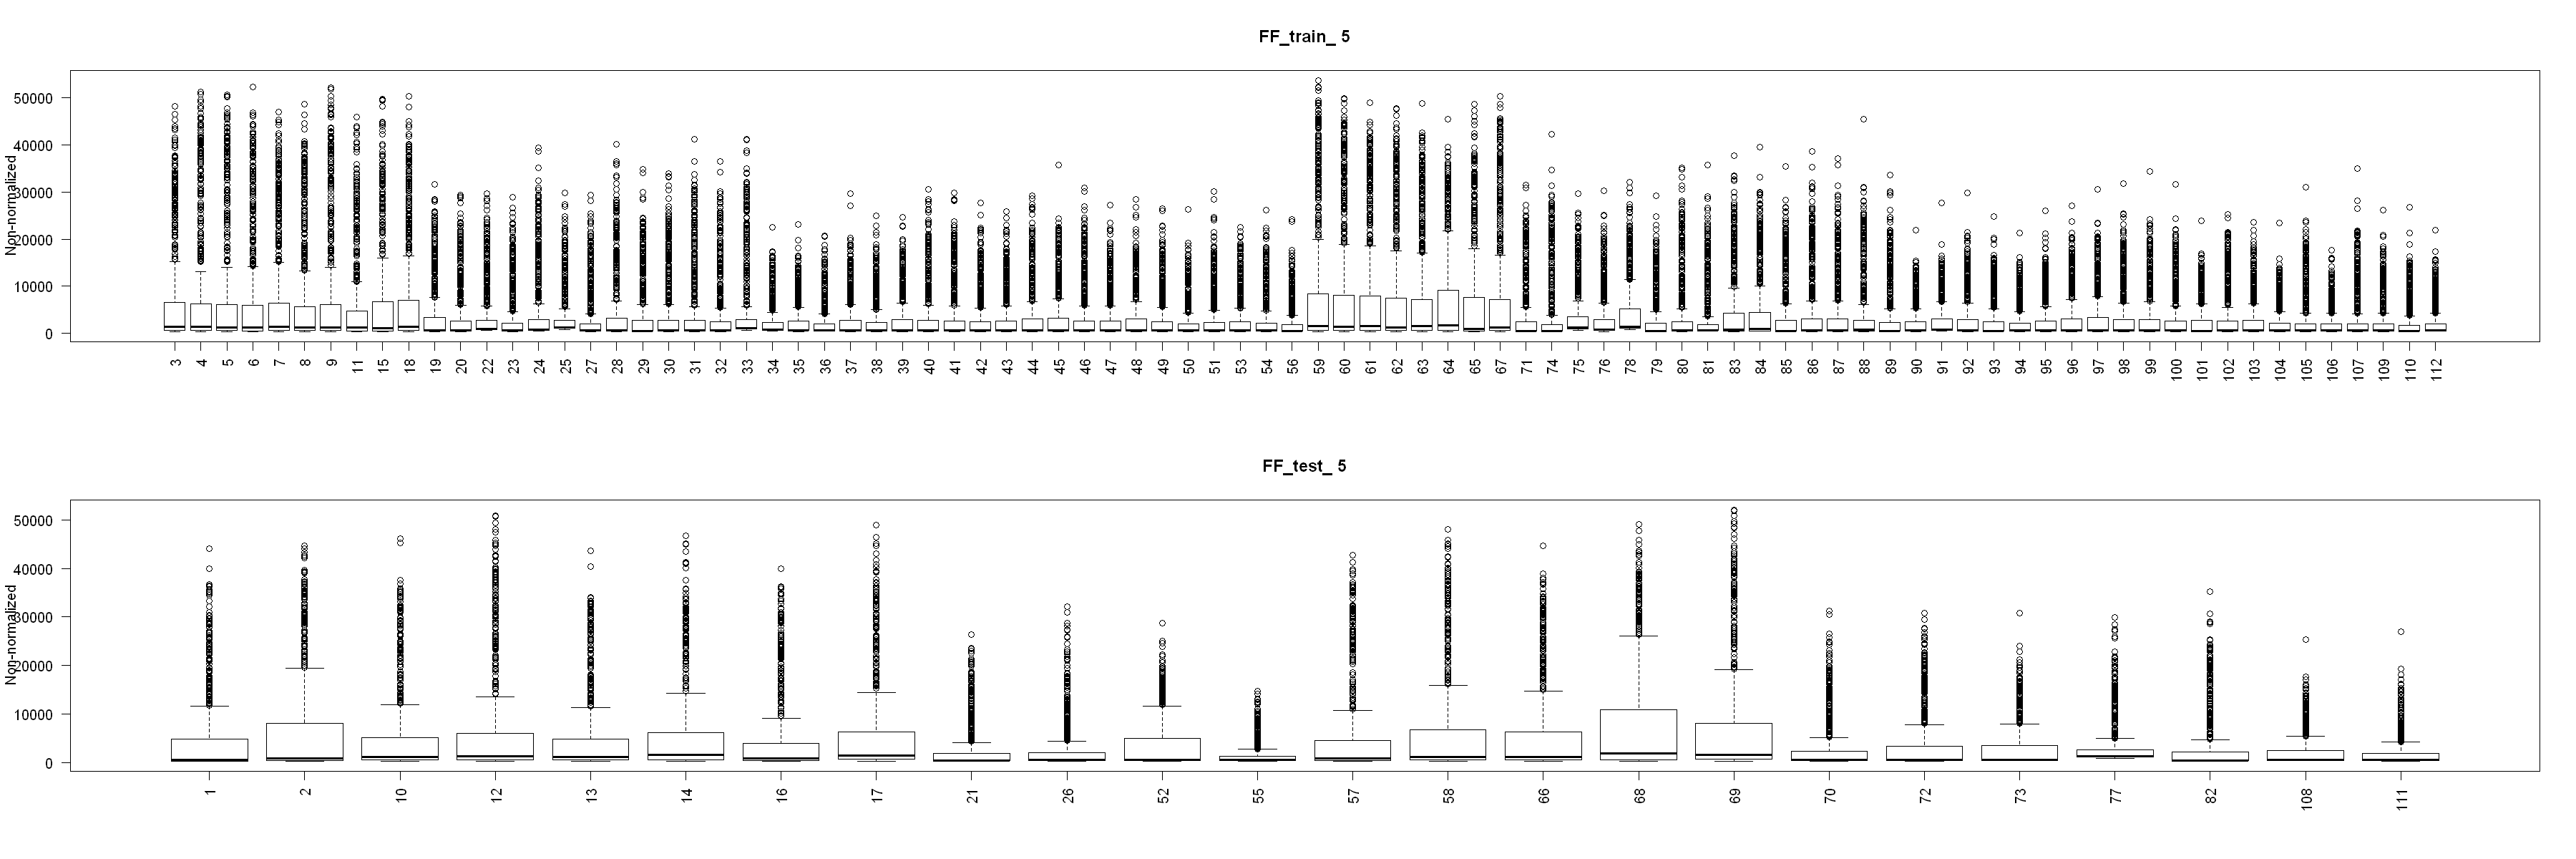

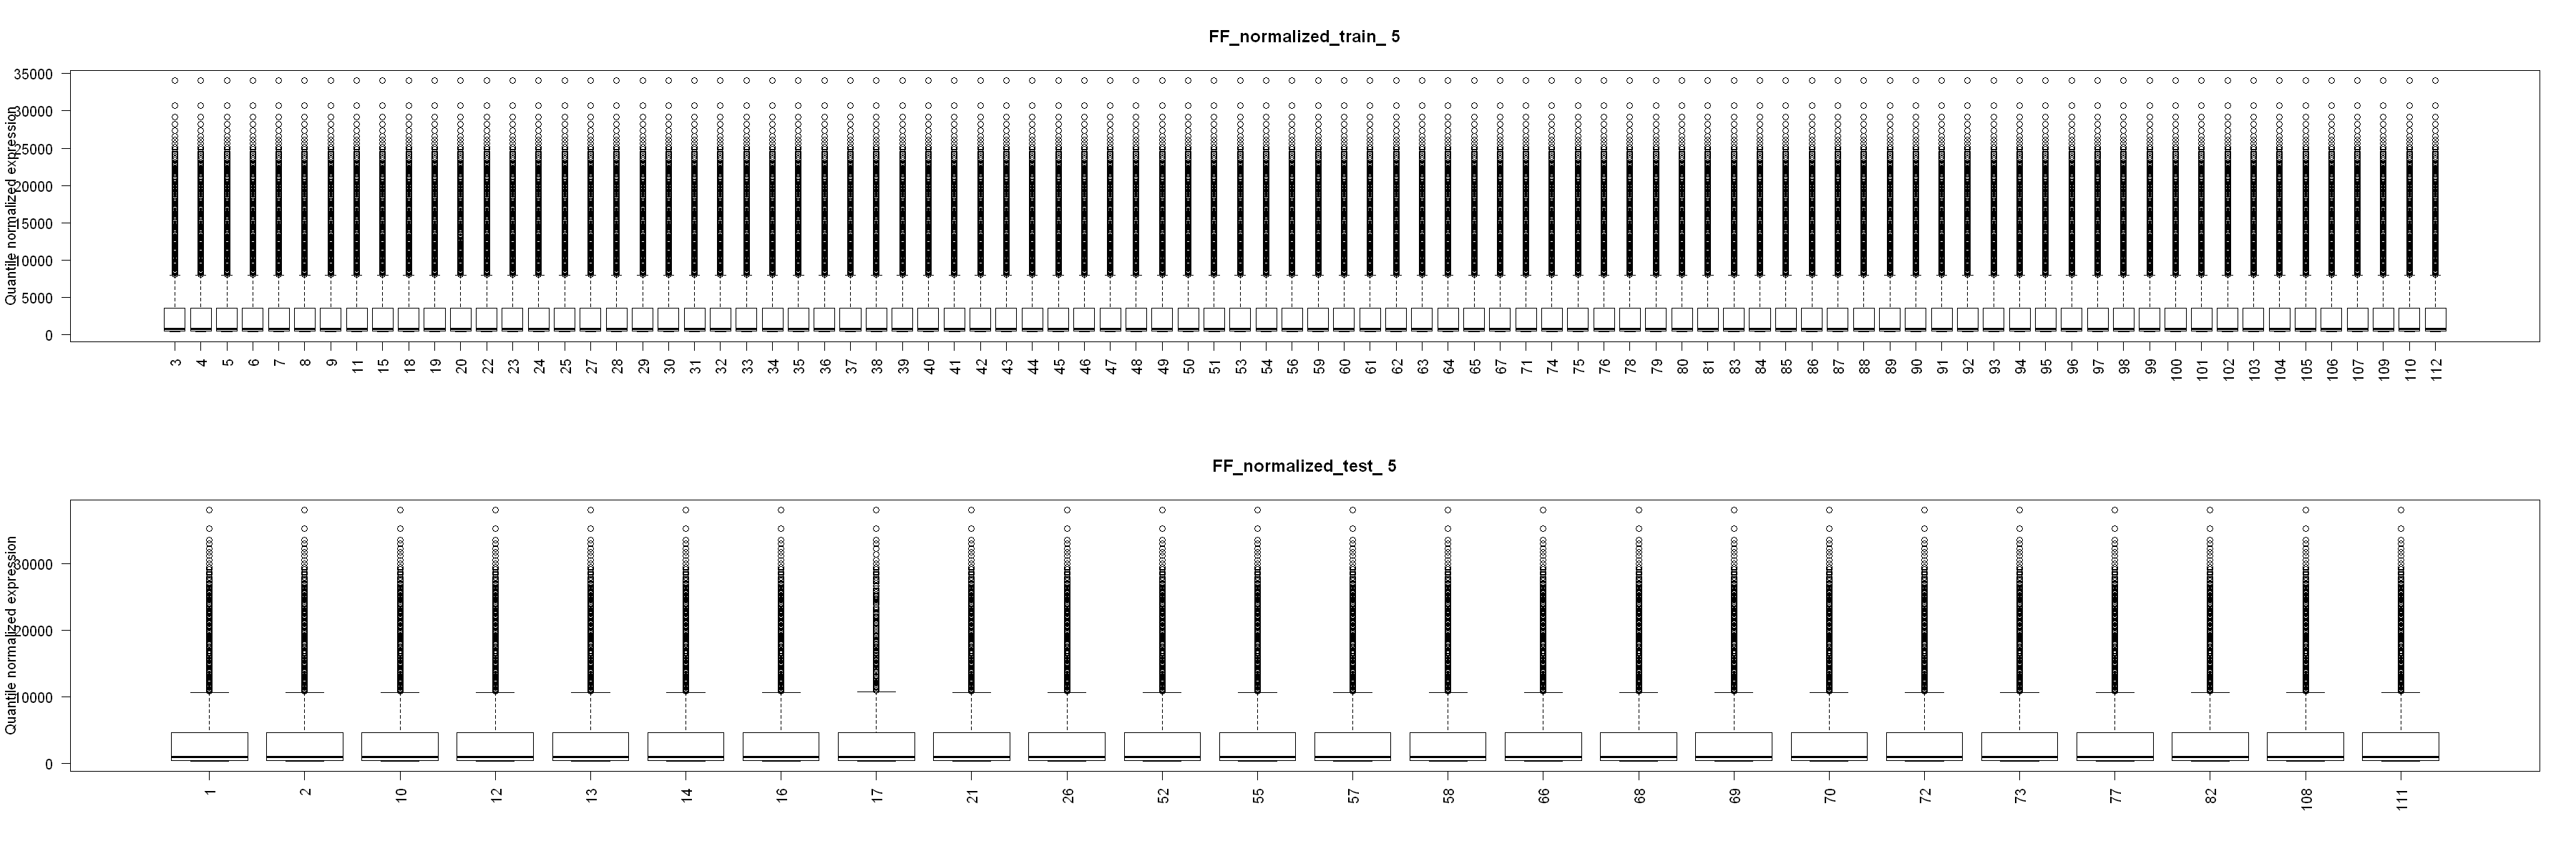

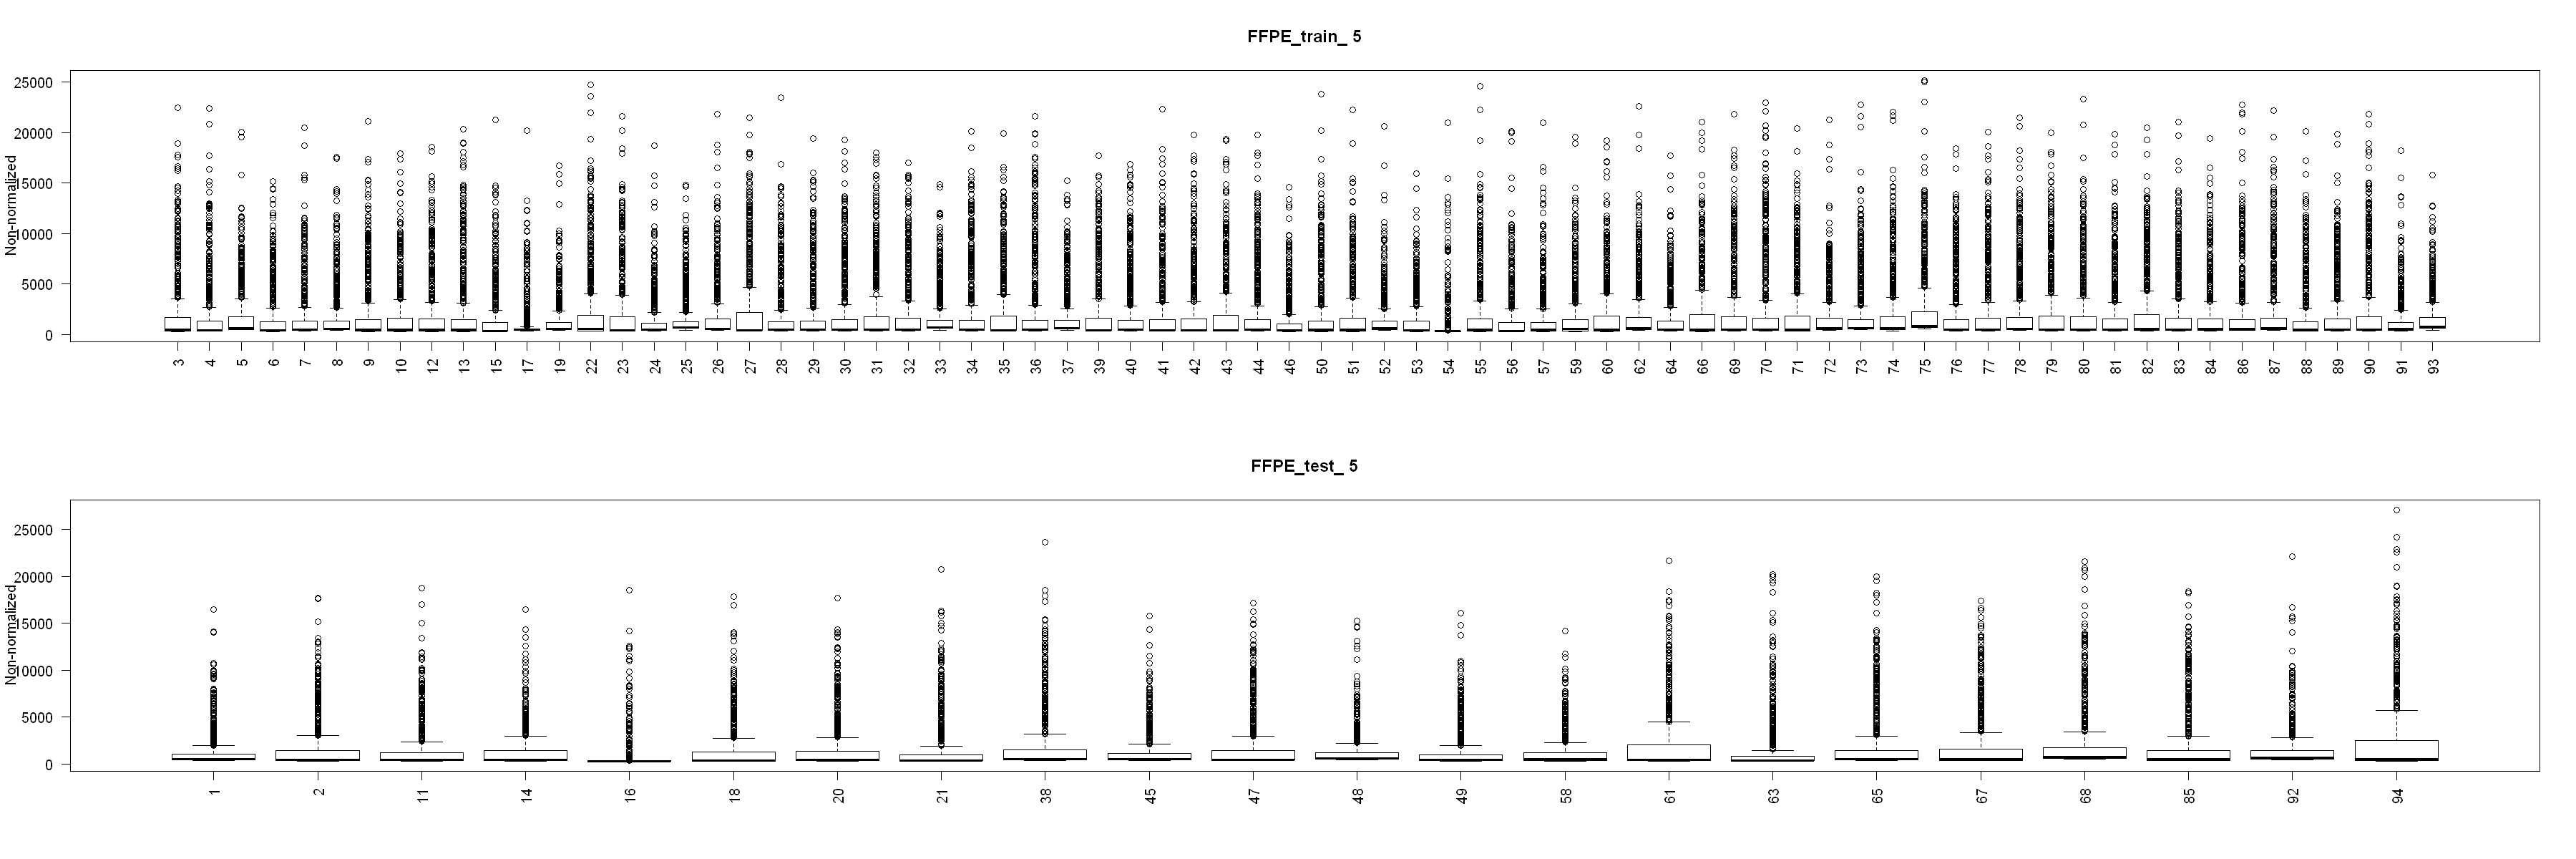

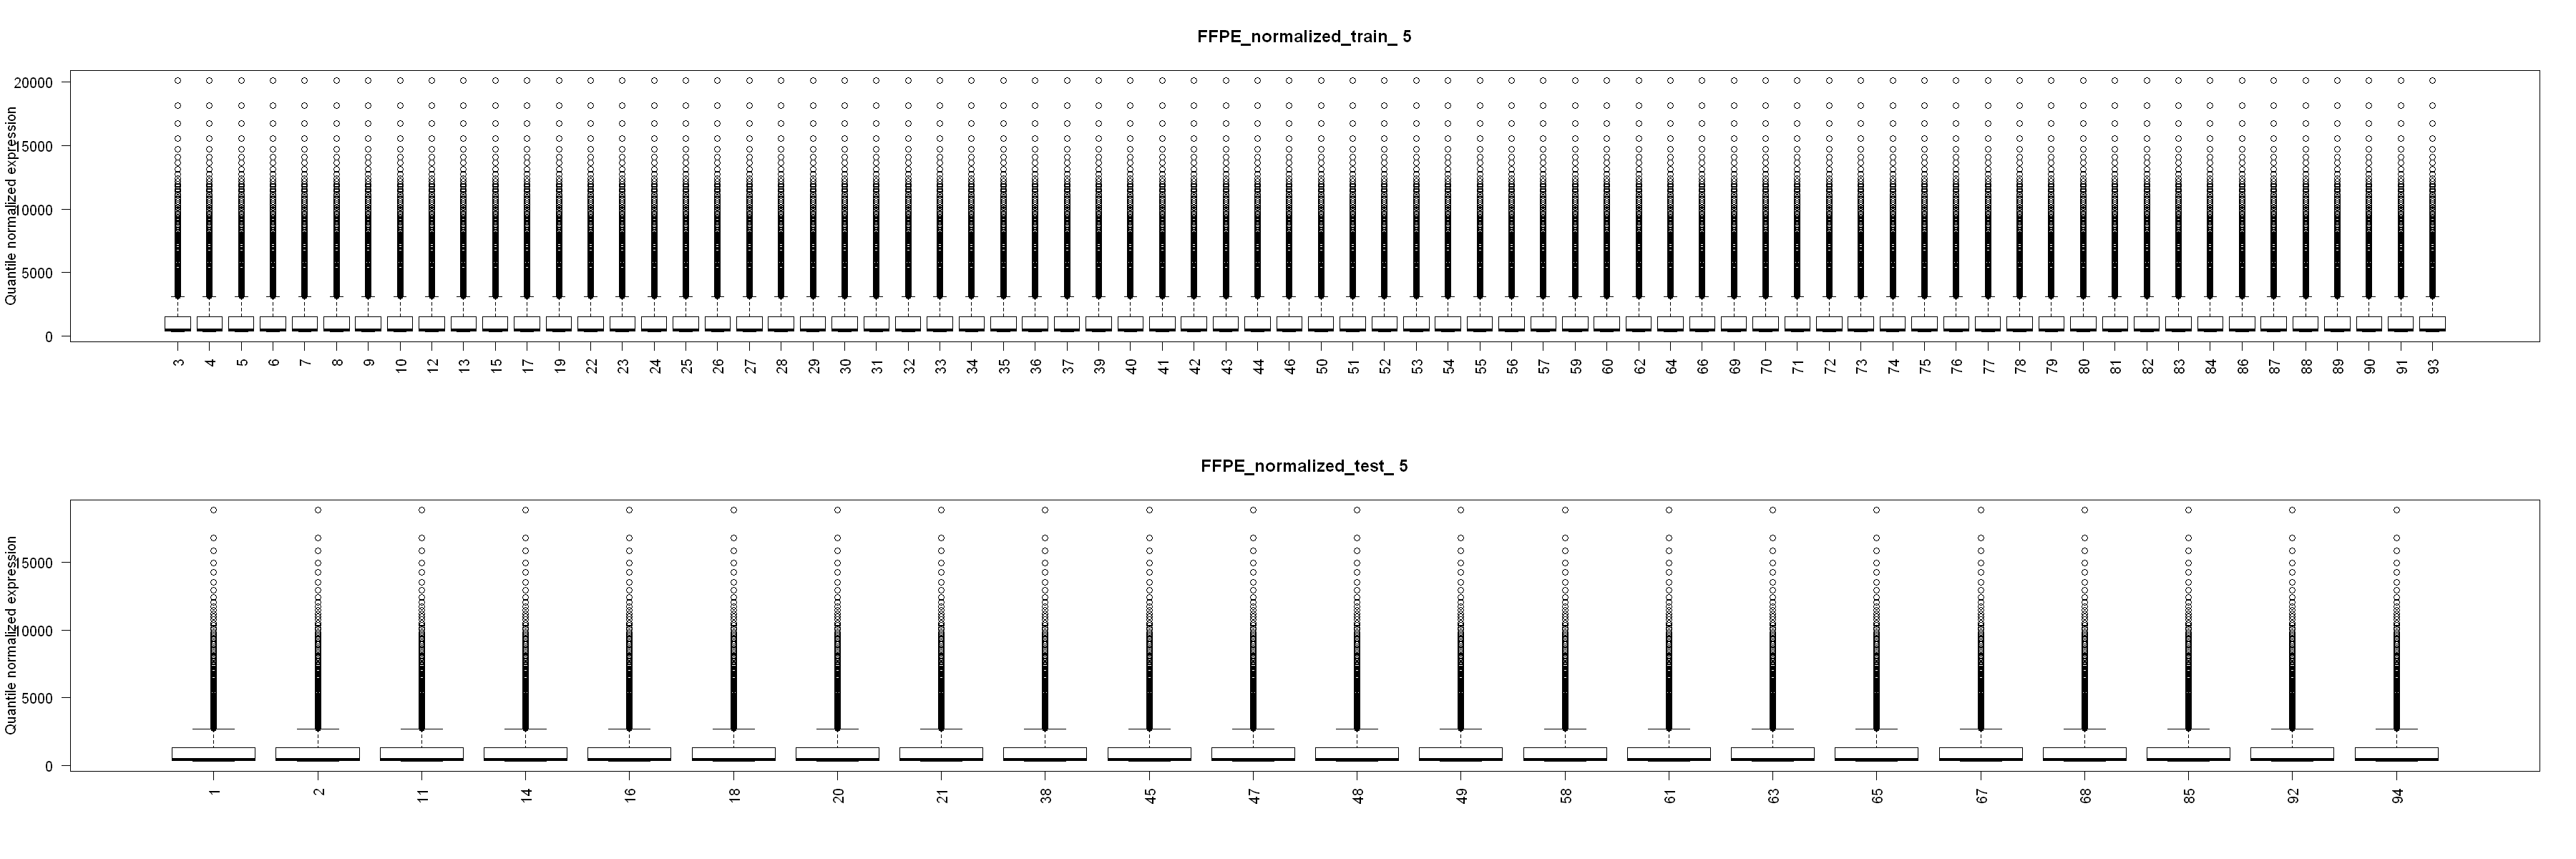

In [12]:
for (i in 1:5) {
  
    options(repr.plot.width=30, repr.plot.height=10)
    
  #get sample IDs for division
  train <- read.csv2(paste("GSE36681/joint-norm/GSE36681_FF_cv_train_", i, ".csv", sep=""))
  train.samples <- train$ID
  test <- read.csv2(paste("GSE36681/joint-norm/GSE36681_FF_cv_val_", i, ".csv", sep=""))
  test.samples <- test$ID
  
  # divide intro train and test data
  file.name <- "reproducibility/sep-norm/GSE36681/GSE36681_FF_non-norm"
  
  FF.matrix.split <- splitRealWorldData(name=file.name, 
                                        count.matrix=FF.matrix, 
                                        annotation=FF.annotation, 
                                        negative.samples=56, 
                                        positive.samples=56, 
                                        train.fraction=0.8, 
                                        by.sample=TRUE, 
                                        train.samples=train.samples, 
                                        test.samples=test.samples)
  
  FF.train.data.set <- FF.matrix.split$train.data.set 
  FF.train.annots <- as.numeric(FF.matrix.split$train.annots[1,])
  FF.test.data.set <- FF.matrix.split$test.data.set
  FF.test.annots <- as.numeric(FF.matrix.split$test.annots[1,])
  
  file.name <- paste("reproducibility/sep-norm/GSE36681/GSE36681_FF_non-norm_train_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, FF.train.annots, FF.train.data.set)
  
  file.name <- paste("reproducibility/sep-norm/GSE36681/GSE36681_FF_non-norm_test_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, FF.test.annots, FF.test.data.set)
  
  #jpeg(file=paste("FF_non-norm_", i, ".jpeg", sep=""), width=1500, height=500)
  par(mfrow=c(2,1))
  boxplot(FF.train.data.set, col = "#FFFFFF", las = 2, main=paste("FF_train_", i), ylab="Non-normalized")
  boxplot(FF.test.data.set, col = "#FFFFFF", las = 2, main=paste("FF_test_", i), ylab="Non-normalized")
  #dev.off()
  
  FF.train.data.set.norm <- normalizeQuantiles(FF.train.data.set)
  FF.test.data.set.norm <- normalizeQuantiles(FF.test.data.set)
  
  file.name <- paste("reproducibility/sep-norm/GSE36681/GSE36681_FF_sep-norm_train_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, FF.train.annots, FF.train.data.set.norm)
  
  file.name <- paste("reproducibility/sep-norm/GSE36681/GSE36681_FF_sep-norm_test_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, FF.test.annots, FF.test.data.set.norm)
  
  #jpeg(file=paste("FF_normalized_", i, ".jpeg", sep=""), width=1500, height=500)
  par(mfrow=c(2,1))
  boxplot(FF.train.data.set.norm, col = "#FFFFFF", las = 2, main=paste("FF_normalized_train_", i), ylab="Quantile normalized expression")
  boxplot(FF.test.data.set.norm, col = "#FFFFFF", las = 2, main=paste("FF_normalized_test_", i), ylab="Quantile normalized expression")
  #dev.off()
  
  #get sample IDs for division
  train <- read.csv2(paste("GSE36681/joint-norm/GSE36681_FFPE_cv_train_", i, ".csv", sep=""))
  train.samples <- train$ID
  test <- read.csv2(paste("GSE36681/joint-norm/GSE36681_FFPE_cv_val_", i, ".csv", sep=""))
  test.samples <- test$ID
  
  # divide intro train and test data
  file.name <- "reproducibility/sep-norm/GSE36681/GSE36681_FFPE_non-norm"
  FFPE.matrix.split <- splitRealWorldData(name=file.name, 
                                          count.matrix=FFPE.matrix, 
                                          annotation=FFPE.annotation, 
                                          negative.samples=47, 
                                          positive.samples=47, 
                                          train.fraction=0.8, 
                                          by.sample=TRUE, 
                                          train.samples=train.samples, 
                                          test.samples=test.samples)
  
  FFPE.train.data.set <- FFPE.matrix.split$train.data.set 
  FFPE.train.annots <- as.numeric(FFPE.matrix.split$train.annots[1,])
  FFPE.test.data.set <- FFPE.matrix.split$test.data.set
  FFPE.test.annots <- as.numeric(FFPE.matrix.split$test.annots[1,])
  
  file.name <- paste("reproducibility/sep-norm/GSE36681/GSE36681_FFPE_non_norm_train_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, FFPE.train.annots, FFPE.train.data.set)
  
  file.name <- paste("reproducibility/sep-norm/GSE36681/GSE36681_FFPE_non_norm_test_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, FFPE.test.annots, FFPE.test.data.set)
  
  #jpeg(file=paste("FFPE_non-norm_", i, ".jpeg", sep=""), width=1500, height=500)
  par(mfrow=c(2,1))
  boxplot(FFPE.train.data.set, col = "#FFFFFF", las = 2, main=paste("FFPE_train_", i), ylab="Non-normalized")
  boxplot(FFPE.test.data.set, col = "#FFFFFF", las = 2, main=paste("FFPE_test_", i), ylab="Non-normalized")
  #dev.off()
  
  FFPE.train.data.set.norm <- normalizeQuantiles(FFPE.train.data.set)
  FFPE.test.data.set.norm <- normalizeQuantiles(FFPE.test.data.set)
  
  file.name <- paste("reproducibility/sep-norm/GSE36681/GSE36681_FFPE_sep-norm_train_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, FFPE.train.annots, FFPE.train.data.set.norm)
  
  file.name <- paste("reproducibility/sep-norm/GSE36681/GSE36681_FFPE_sep-norm_test_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, FFPE.test.annots, FFPE.test.data.set.norm)
  
  #jpeg(file=paste("FFPE_normalized_", i, ".jpeg", sep=""), width=1500, height=500)
  par(mfrow=c(2,1))
  boxplot(FFPE.train.data.set.norm, col = "#FFFFFF", las = 2, main=paste("FFPE_normalized_train_", i), ylab="Quantile normalized expression")
  boxplot(FFPE.test.data.set.norm, col = "#FFFFFF", las = 2, main=paste("FFPE_normalized_test_", i), ylab="Quantile normalized expression")
  #dev.off()

}